In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import set_config
from tempfile import TemporaryDirectory
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import KBinsDiscretizer
from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.discretisation import EqualWidthDiscretiser
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import LogCpTransformer
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from feature_engine.encoding import OneHotEncoder
from feature_engine.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
import numpy as np
import warnings
# import the necessary packages

<frozen importlib._bootstrap>:488: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


In [3]:
warnings.filterwarnings('ignore')
set_config(transform_output="pandas")

In [4]:
target_column = "loan_status"

In [5]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 150)

In [6]:
def removeArtifacts(data, original):
    for col in data.select_dtypes(include='object').columns:
        data[col] = data[col].where(data[col].isin(original[col].unique()), np.nan)
# remove categorical artifacts

In [7]:
def handleOriginal(original, test_df):
    original.insert(0, 'id', range(test_df['id'].max()+1, test_df['id'].max() + 1 + len(original)))

In [8]:
original = pd.read_csv("original.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train['dataset'] = 'train'
test['dataset'] = 'test'
original['dataset'] = 'original'

handleOriginal(original, test)

data = pd.concat([train, test, original]).reset_index(drop=True)
data_copy = data.copy()

In [9]:
data.head()

id  person_age  person_income person_home_ownership  person_emp_length loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   0          37          35000                  RENT                0.0   EDUCATION          B       6000          11.49                 0.17   
1   1          22          56000                   OWN                6.0     MEDICAL          C       4000          13.35                 0.07   
2   2          29          28800                   OWN                8.0    PERSONAL          A       6000           8.90                 0.21   
3   3          30          70000                  RENT               14.0     VENTURE          B      12000          11.11                 0.17   
4   4          22          60000                  RENT                2.0     MEDICAL          A       6000           6.92                 0.10   

  cb_person_default_on_file  cb_person_cred_hist_length  loan_status dataset  
0                         N                          14          0.0   train  
1                         N                           2          0.0   train  
2                         N                          10          0.0   train  
3                         N                           5          0.0   train  
4                         N                           3          0.0   train

In [10]:
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          32581 non-null  int64  
 1   person_age                  32581 non-null  int64  
 2   person_income               32581 non-null  int64  
 3   person_home_ownership       32581 non-null  object 
 4   person_emp_length           31686 non-null  float64
 5   loan_intent                 32581 non-null  object 
 6   loan_grade                  32581 non-null  object 
 7   loan_amnt                   32581 non-null  int64  
 8   loan_int_rate               29465 non-null  float64
 9   loan_status                 32581 non-null  int64  
 10  loan_percent_income         32581 non-null  float64
 11  cb_person_default_on_file   32581 non-null  object 
 12  cb_person_cred_hist_length  32581 non-null  int64  
 13  dataset                     325

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
 13  dataset                     586

In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39098 non-null  int64  
 1   person_age                  39098 non-null  int64  
 2   person_income               39098 non-null  int64  
 3   person_home_ownership       39098 non-null  object 
 4   person_emp_length           39098 non-null  float64
 5   loan_intent                 39098 non-null  object 
 6   loan_grade                  39098 non-null  object 
 7   loan_amnt                   39098 non-null  int64  
 8   loan_int_rate               39098 non-null  float64
 9   loan_percent_income         39098 non-null  float64
 10  cb_person_default_on_file   39098 non-null  object 
 11  cb_person_cred_hist_length  39098 non-null  int64  
 12  dataset                     39098 non-null  object 
dtypes: float64(3), int64(5), object

In [13]:
data.isna().sum().sort_values(ascending=False)

loan_status                   39098
loan_int_rate                  3116
person_emp_length               895
id                                0
person_age                        0
person_income                     0
person_home_ownership             0
loan_intent                       0
loan_grade                        0
loan_amnt                         0
loan_percent_income               0
cb_person_default_on_file         0
cb_person_cred_hist_length        0
dataset                           0
dtype: int64

In [14]:
def show_missing_values(data, palette="viridis"):
    missing_values = data.isna().sum().sort_values(ascending=False)
    sns.barplot(x=missing_values.values, y=missing_values.index,palette=palette)

<Axes: xlabel='dataset', ylabel='count'>

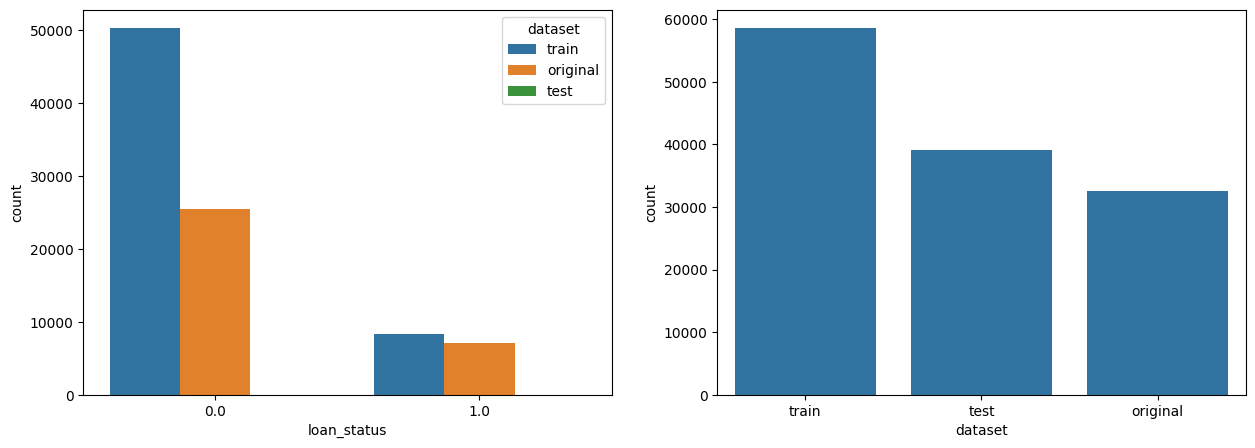

In [15]:
fig,axs = plt.subplots(figsize=(15,5),ncols=2)

sns.countplot(data,x="loan_status",hue="dataset",ax=axs[0])
sns.countplot(data, x='dataset',ax=axs[1])

<Axes: xlabel='cb_person_default_on_file', ylabel='count'>

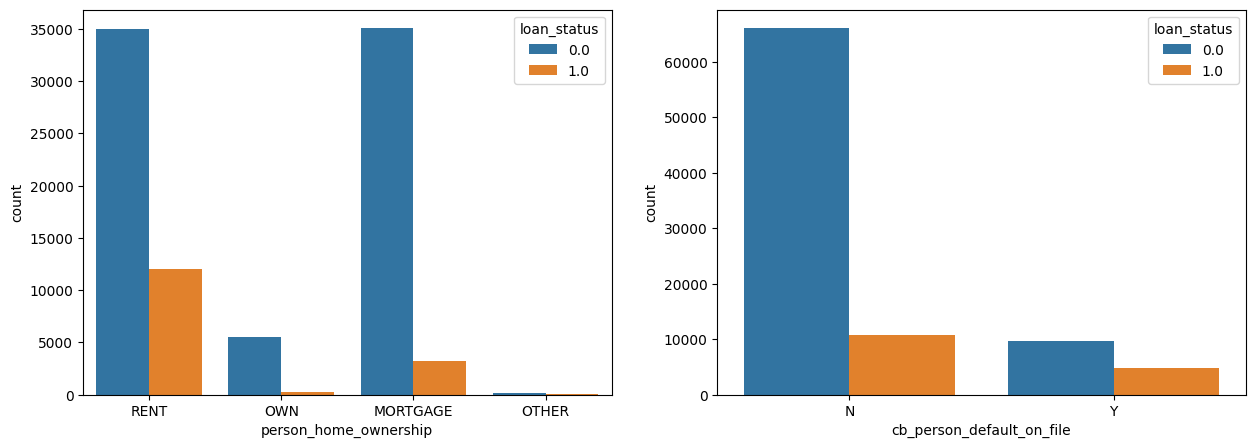

In [16]:
fig,axs = plt.subplots(figsize=(15,5),ncols=2)

sns.countplot(data, x="person_home_ownership",hue=target_column,ax=axs[0])
sns.countplot(data, x="cb_person_default_on_file",hue=target_column,ax=axs[1])

<Axes: xlabel='loan_grade', ylabel='count'>

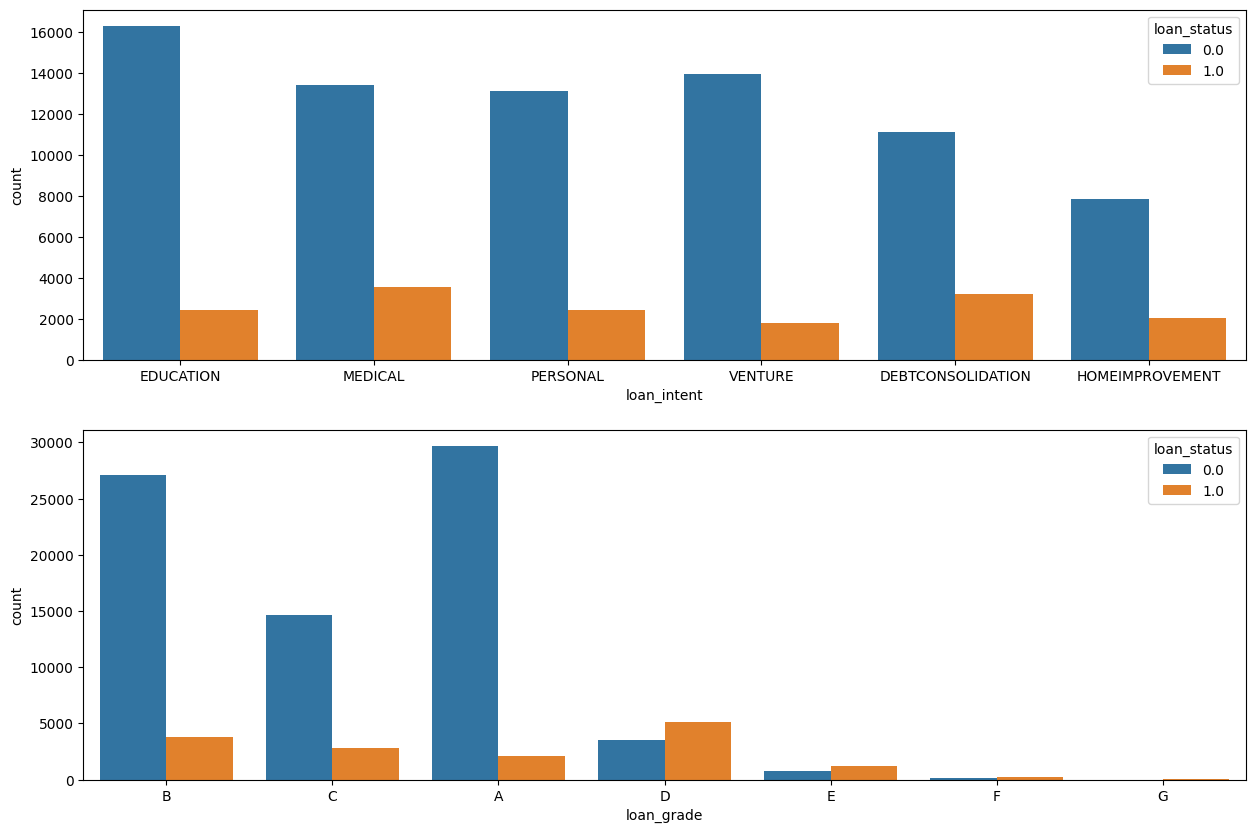

In [17]:
fig,axs = plt.subplots(figsize=(15,10),nrows=2)
sns.countplot(data, x="loan_intent",hue=target_column,ax=axs[0])
sns.countplot(data, x="loan_grade",hue=target_column,ax=axs[1])

<Axes: xlabel='cb_person_cred_hist_length'>

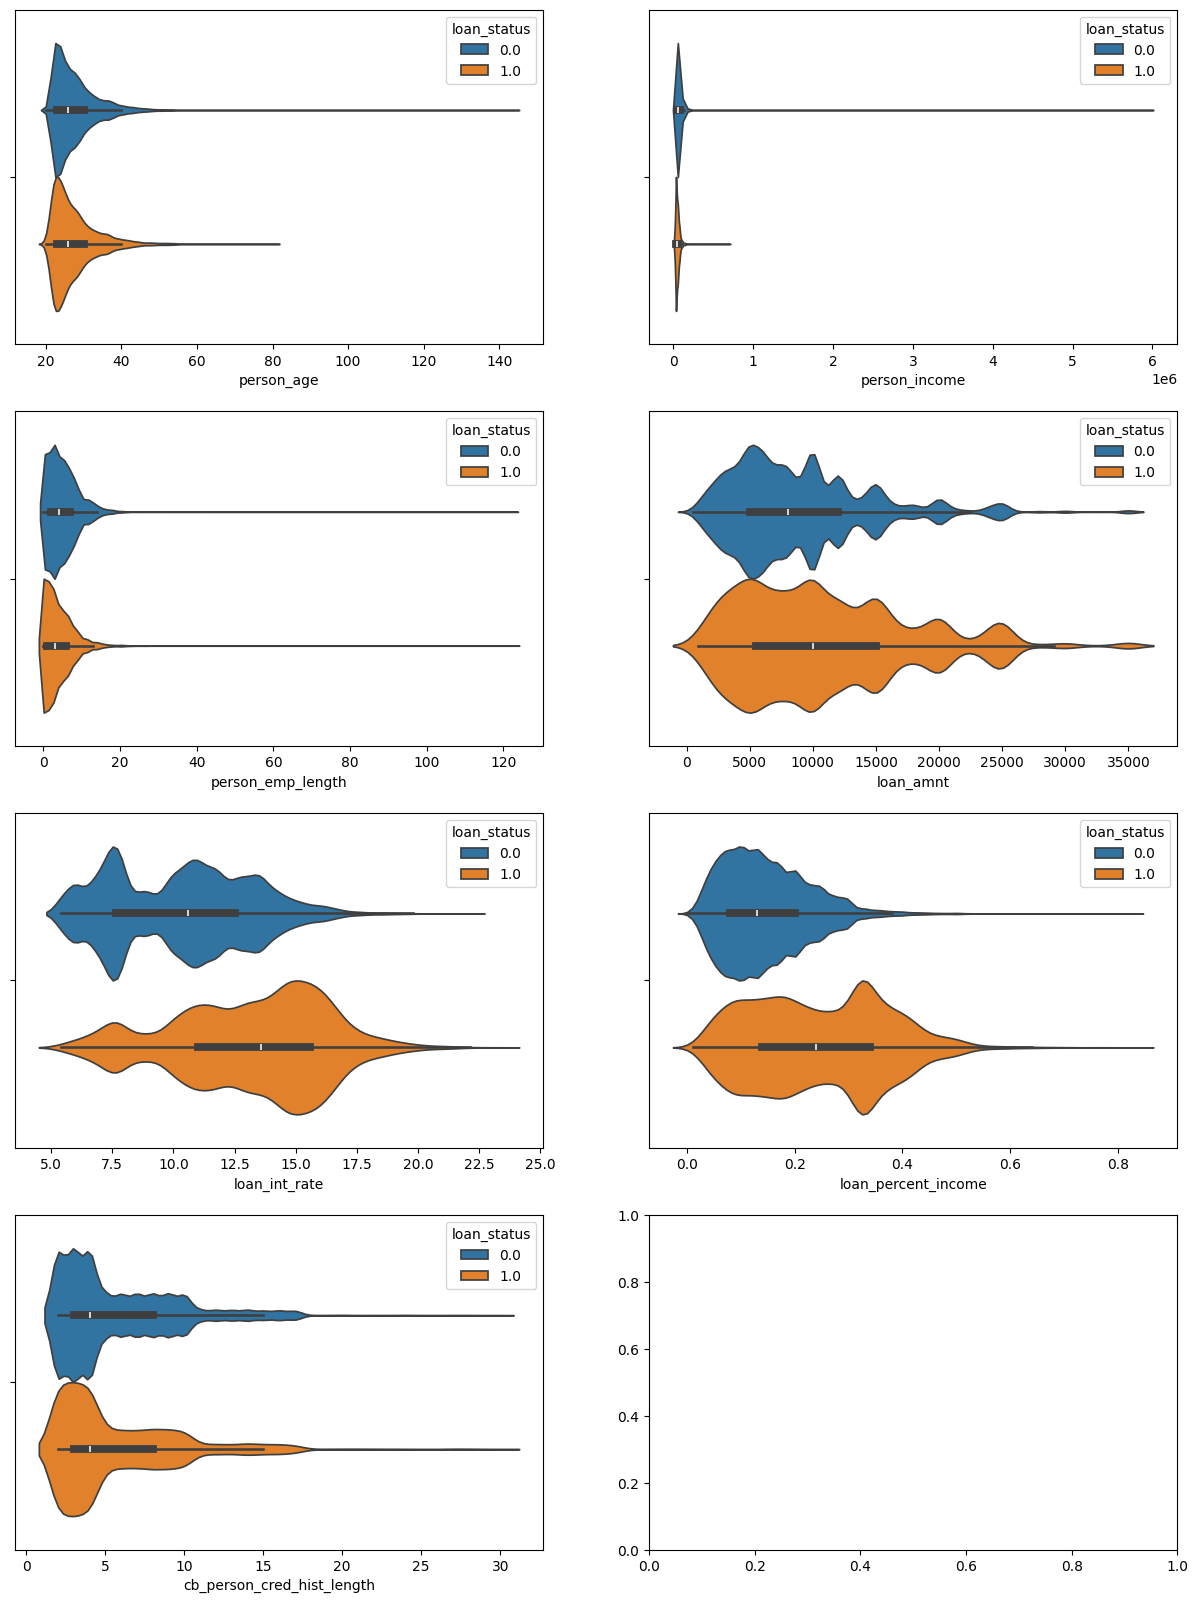

In [18]:
fig, axs = plt.subplots(figsize=(15,20),nrows=4, ncols=2)

sns.violinplot(data, x="person_age",hue=target_column,ax=axs[0][0])
sns.violinplot(data, x="person_income",hue=target_column,ax=axs[0][1])
sns.violinplot(data, x="person_emp_length",hue=target_column,ax=axs[1][0])
sns.violinplot(data, x="loan_amnt",hue=target_column,ax=axs[1][1])
sns.violinplot(data, x="loan_int_rate",hue=target_column,ax=axs[2][0])
sns.violinplot(data, x="loan_percent_income",hue=target_column,ax=axs[2][1])
sns.violinplot(data, x="cb_person_cred_hist_length",hue=target_column,ax=axs[3][0])

In [19]:
train.describe()

id    person_age  person_income  person_emp_length     loan_amnt  loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
count  58645.000000  58645.000000   5.864500e+04       58645.000000  58645.000000   58645.000000         58645.000000                58645.000000   
mean   29322.000000     27.550857   6.404617e+04           4.701015   9217.556518      10.677874             0.159238                    5.813556   
std    16929.497605      6.033216   3.793111e+04           3.959784   5563.807384       3.034697             0.091692                    4.029196   
min        0.000000     20.000000   4.200000e+03           0.000000    500.000000       5.420000             0.000000                    2.000000   
25%    14661.000000     23.000000   4.200000e+04           2.000000   5000.000000       7.880000             0.090000                    3.000000   
50%    29322.000000     26.000000   5.800000e+04           4.000000   8000.000000      10.750000             0.140000                    4.000000   
75%    43983.000000     30.000000   7.560000e+04           7.000000  12000.000000      12.990000             0.210000                    8.000000   
max    58644.000000    123.000000   1.900000e+06         123.000000  35000.000000      23.220000             0.830000                   30.000000   

        loan_status  
count  58645.000000  
mean       0.142382  
std        0.349445  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

In [20]:
test.describe()

id    person_age  person_income  person_emp_length     loan_amnt  loan_int_rate  loan_percent_income  cb_person_cred_hist_length
count  39098.000000  39098.000000   3.909800e+04       39098.000000  39098.000000   39098.000000         39098.000000                39098.000000
mean   78193.500000     27.566781   6.406046e+04           4.687068   9251.466188      10.661216             0.159573                    5.830707
std    11286.764749      6.032761   3.795583e+04           3.868395   5576.254680       3.020220             0.091633                    4.072157
min    58645.000000     20.000000   4.000000e+03           0.000000    700.000000       5.420000             0.000000                    2.000000
25%    68419.250000     23.000000   4.200000e+04           2.000000   5000.000000       7.880000             0.090000                    3.000000
50%    78193.500000     26.000000   5.800000e+04           4.000000   8000.000000      10.750000             0.140000                    4.000000
75%    87967.750000     30.000000   7.588500e+04           7.000000  12000.000000      12.990000             0.210000                    8.000000
max    97742.000000     94.000000   1.900000e+06          42.000000  35000.000000      22.110000             0.730000                   30.000000

In [21]:
original.describe()

id    person_age  person_income  person_emp_length     loan_amnt  loan_int_rate   loan_status  loan_percent_income  \
count   32581.000000  32581.000000   3.258100e+04       31686.000000  32581.000000   29465.000000  32581.000000         32581.000000   
mean   114033.000000     27.734600   6.607485e+04           4.789686   9589.371106      11.011695      0.218164             0.170203   
std      9405.468897      6.348078   6.198312e+04           4.142630   6322.086646       3.240459      0.413006             0.106782   
min     97743.000000     20.000000   4.000000e+03           0.000000    500.000000       5.420000      0.000000             0.000000   
25%    105888.000000     23.000000   3.850000e+04           2.000000   5000.000000       7.900000      0.000000             0.090000   
50%    114033.000000     26.000000   5.500000e+04           4.000000   8000.000000      10.990000      0.000000             0.150000   
75%    122178.000000     30.000000   7.920000e+04           7.000000  12200.000000      13.470000      0.000000             0.230000   
max    130323.000000    144.000000   6.000000e+06         123.000000  35000.000000      23.220000      1.000000             0.830000   

       cb_person_cred_hist_length  
count                32581.000000  
mean                     5.804211  
std                      4.055001  
min                      2.000000  
25%                      3.000000  
50%                      4.000000  
75%                      8.000000  
max                     30.000000

<Axes: xlabel='cb_person_default_on_file', ylabel='count'>

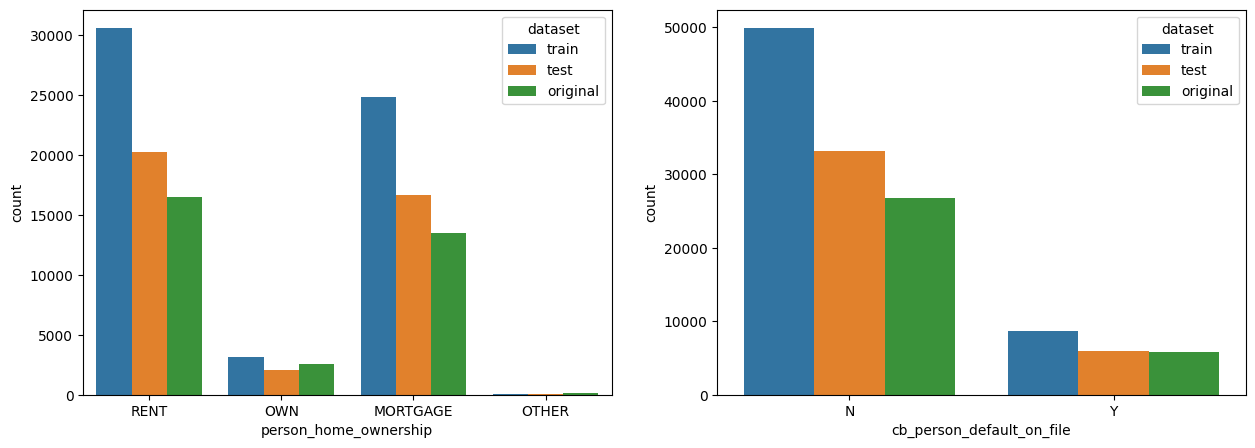

In [22]:
fig,axs = plt.subplots(figsize=(15,5),ncols=2)

sns.countplot(data, x="person_home_ownership",hue='dataset',ax=axs[0])
sns.countplot(data, x="cb_person_default_on_file",hue='dataset',ax=axs[1])

<Axes: xlabel='loan_grade', ylabel='count'>

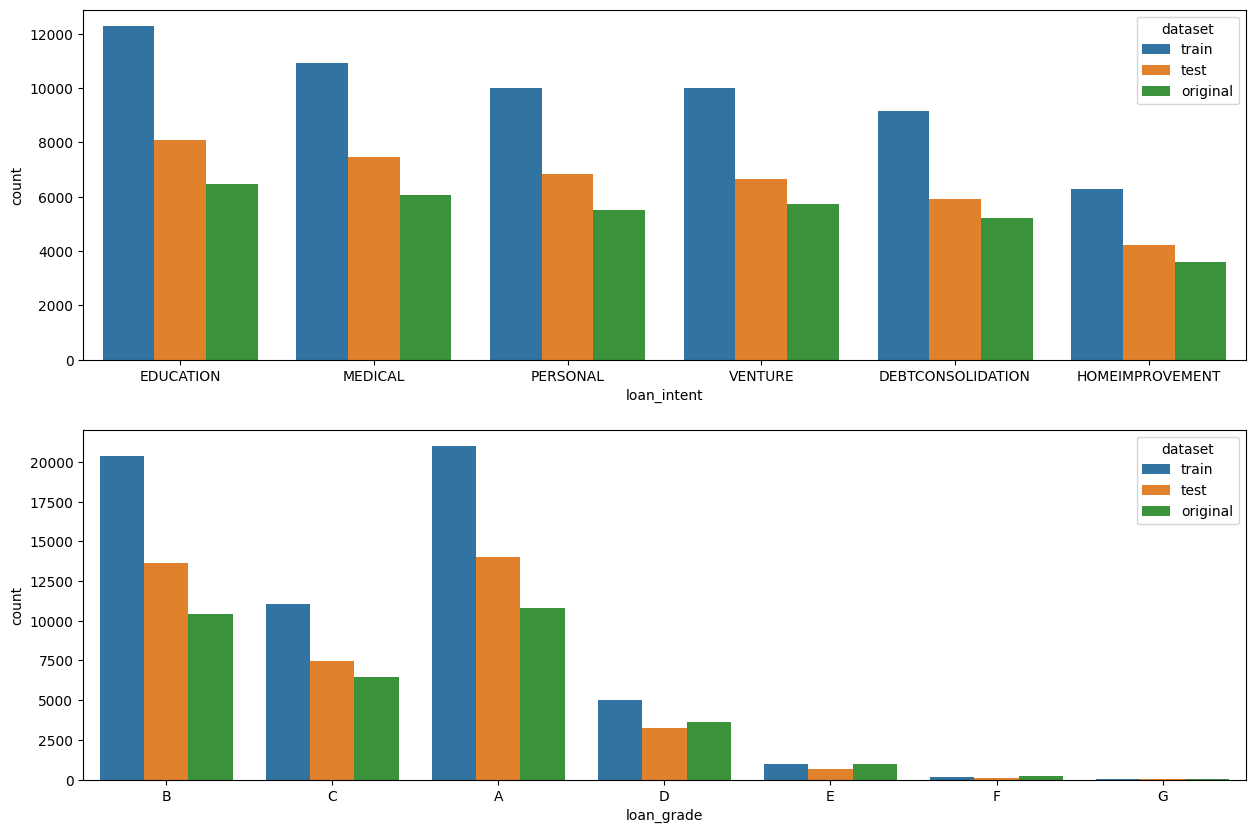

In [23]:
fig,axs = plt.subplots(figsize=(15,10),nrows=2)
sns.countplot(data, x="loan_intent",hue='dataset',ax=axs[0])
sns.countplot(data, x="loan_grade",hue='dataset',ax=axs[1])

<Axes: xlabel='cb_person_cred_hist_length'>

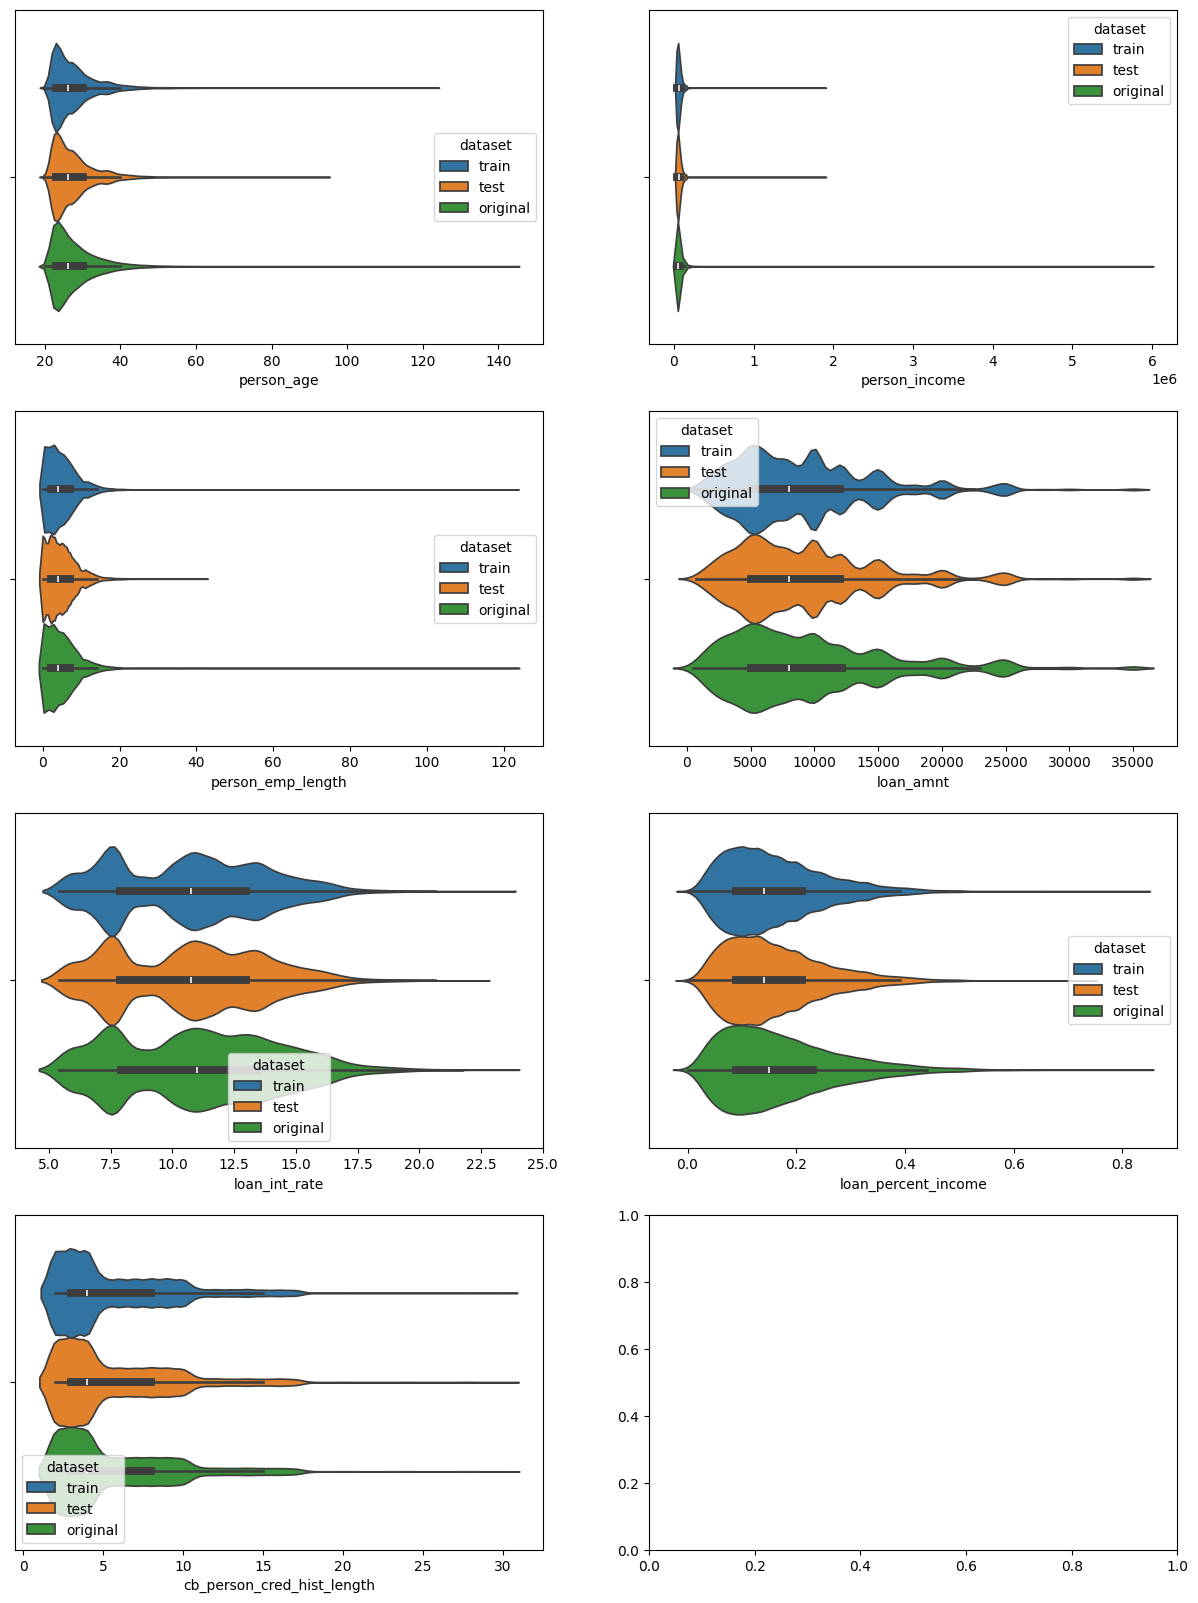

In [24]:
fig, axs = plt.subplots(figsize=(15,20),nrows=4, ncols=2)

sns.violinplot(data, x="person_age",hue='dataset',ax=axs[0][0])
sns.violinplot(data, x="person_income",hue='dataset',ax=axs[0][1])
sns.violinplot(data, x="person_emp_length",hue='dataset',ax=axs[1][0])
sns.violinplot(data, x="loan_amnt",hue='dataset',ax=axs[1][1])
sns.violinplot(data, x="loan_int_rate",hue='dataset',ax=axs[2][0])
sns.violinplot(data, x="loan_percent_income",hue='dataset',ax=axs[2][1])
sns.violinplot(data, x="cb_person_cred_hist_length",hue='dataset',ax=axs[3][0])

<Axes: xlabel='person_income', ylabel='loan_percent_income'>

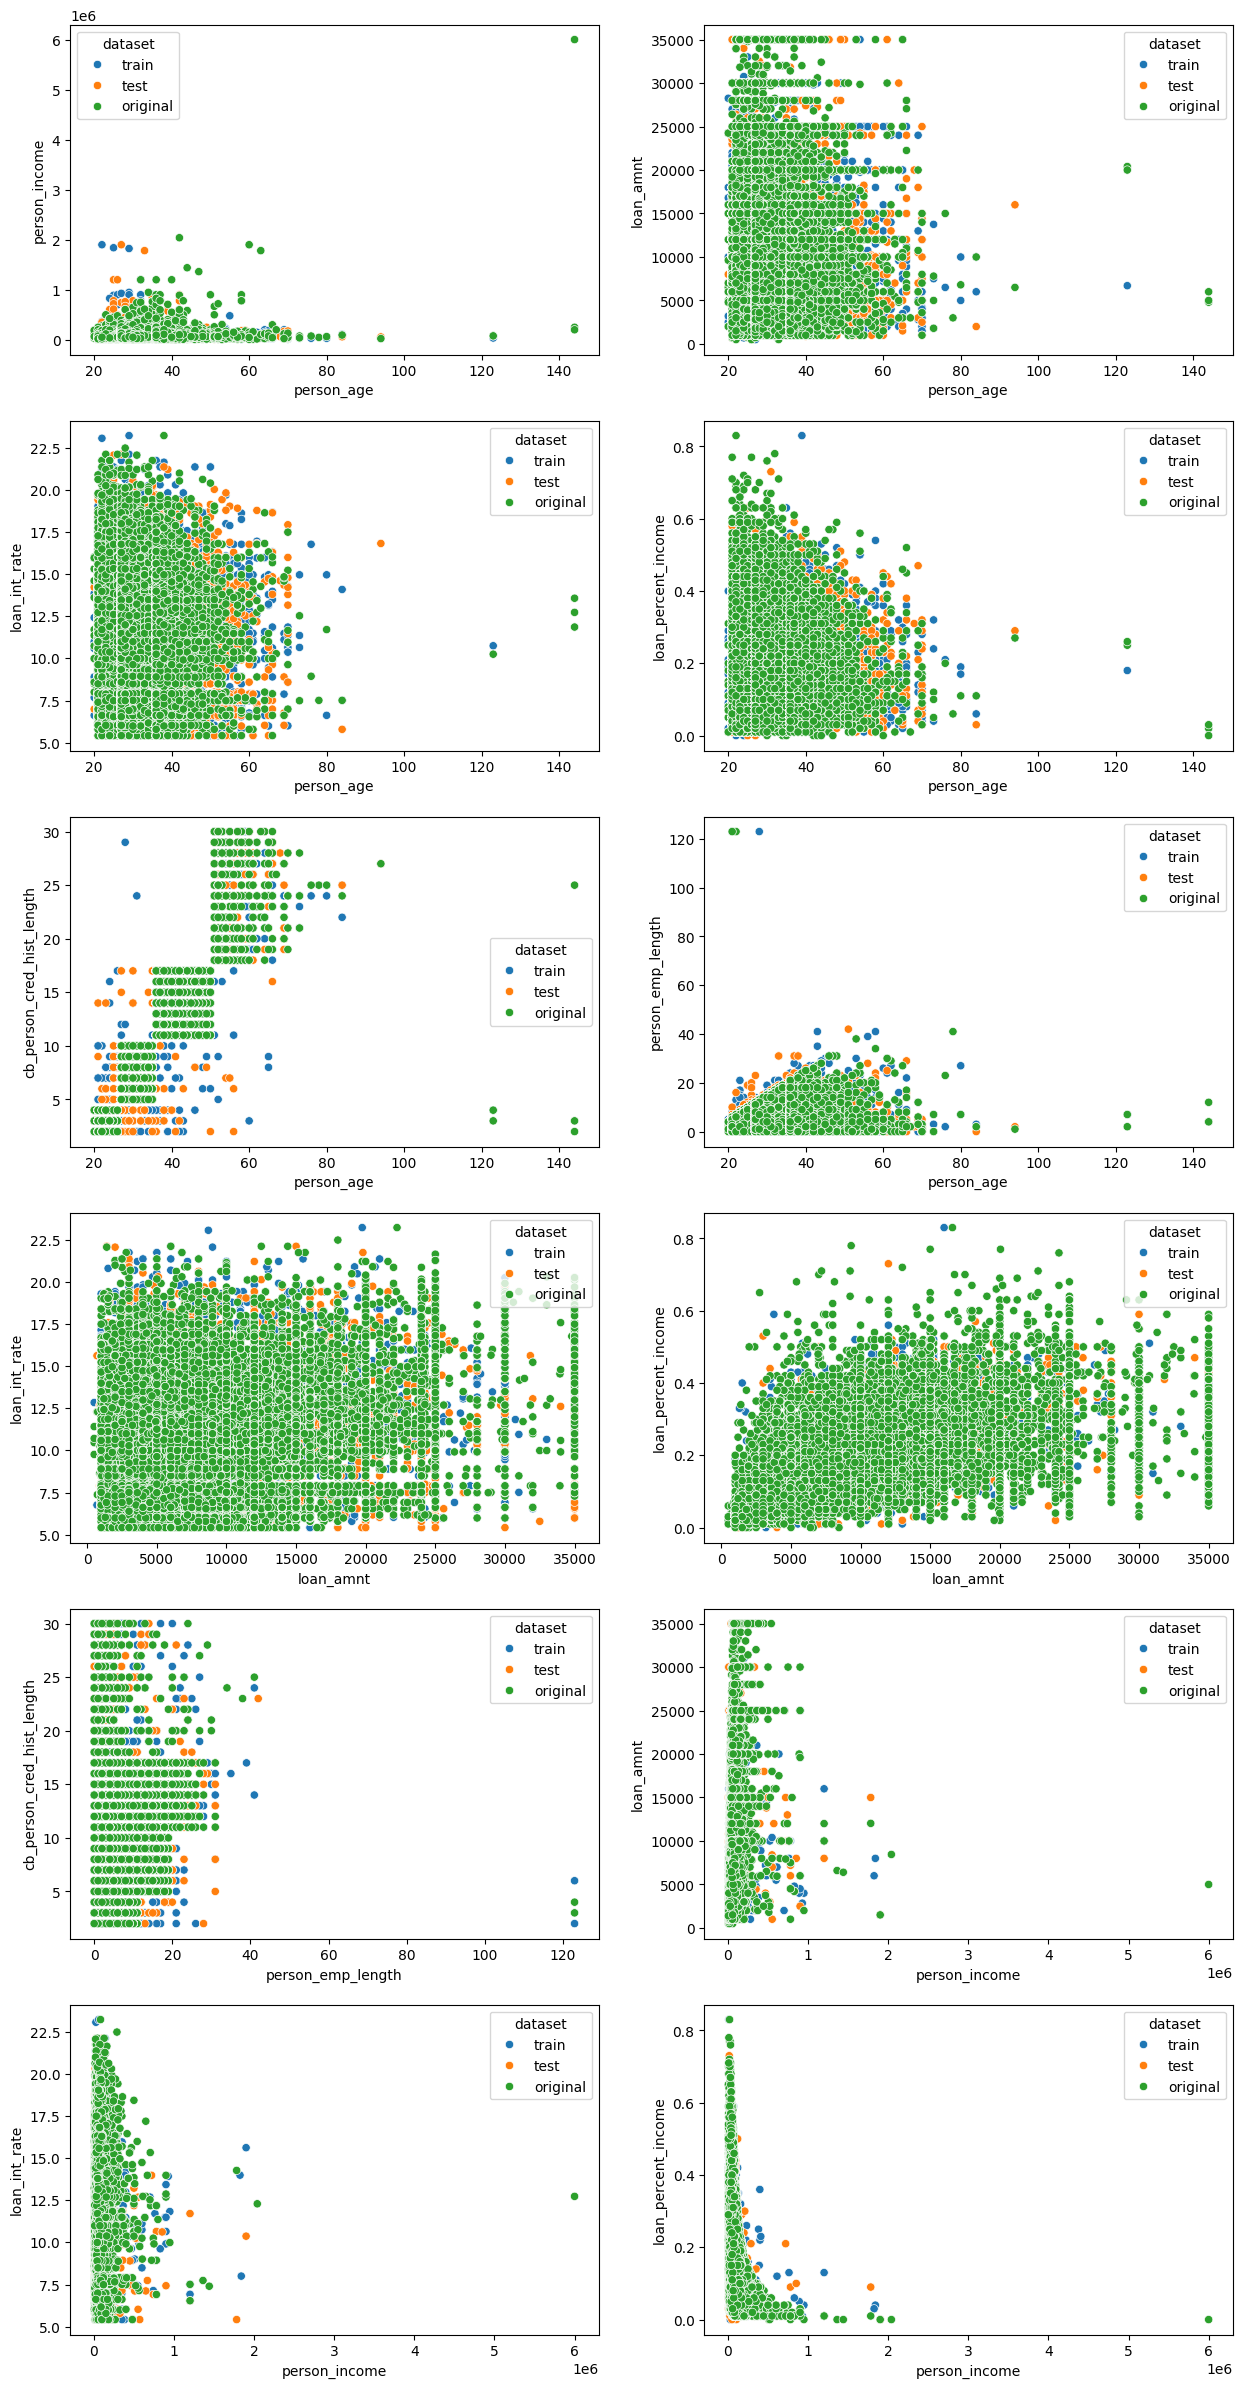

In [25]:
fig, axs = plt.subplots(figsize=(15,30),nrows=6, ncols=2)

sns.scatterplot(data,x="person_age",y="person_income",hue="dataset",ax=axs[0][0])
sns.scatterplot(data,x="person_age",y="loan_amnt",hue="dataset",ax=axs[0][1])
sns.scatterplot(data,x="person_age",y="loan_int_rate",hue="dataset",ax=axs[1][0])
sns.scatterplot(data,x="person_age",y="loan_percent_income",hue="dataset",ax=axs[1][1])
sns.scatterplot(data,x="person_age",y="cb_person_cred_hist_length",hue="dataset",ax=axs[2][0])
sns.scatterplot(data,x="person_age",y="person_emp_length",hue="dataset",ax=axs[2][1])
sns.scatterplot(data,x="loan_amnt",y="loan_int_rate",hue="dataset",ax=axs[3][0])
sns.scatterplot(data,x="loan_amnt",y="loan_percent_income",hue="dataset",ax=axs[3][1])
sns.scatterplot(data,x="person_emp_length",y="cb_person_cred_hist_length",hue="dataset",ax=axs[4][0])
sns.scatterplot(data,x="person_income",y="loan_amnt",hue="dataset",ax=axs[4][1])
sns.scatterplot(data,x="person_income",y="loan_int_rate",hue="dataset",ax=axs[5][0])
sns.scatterplot(data,x="person_income",y="loan_percent_income",hue="dataset",ax=axs[5][1])

<Axes: xlabel='loan_percent_income'>

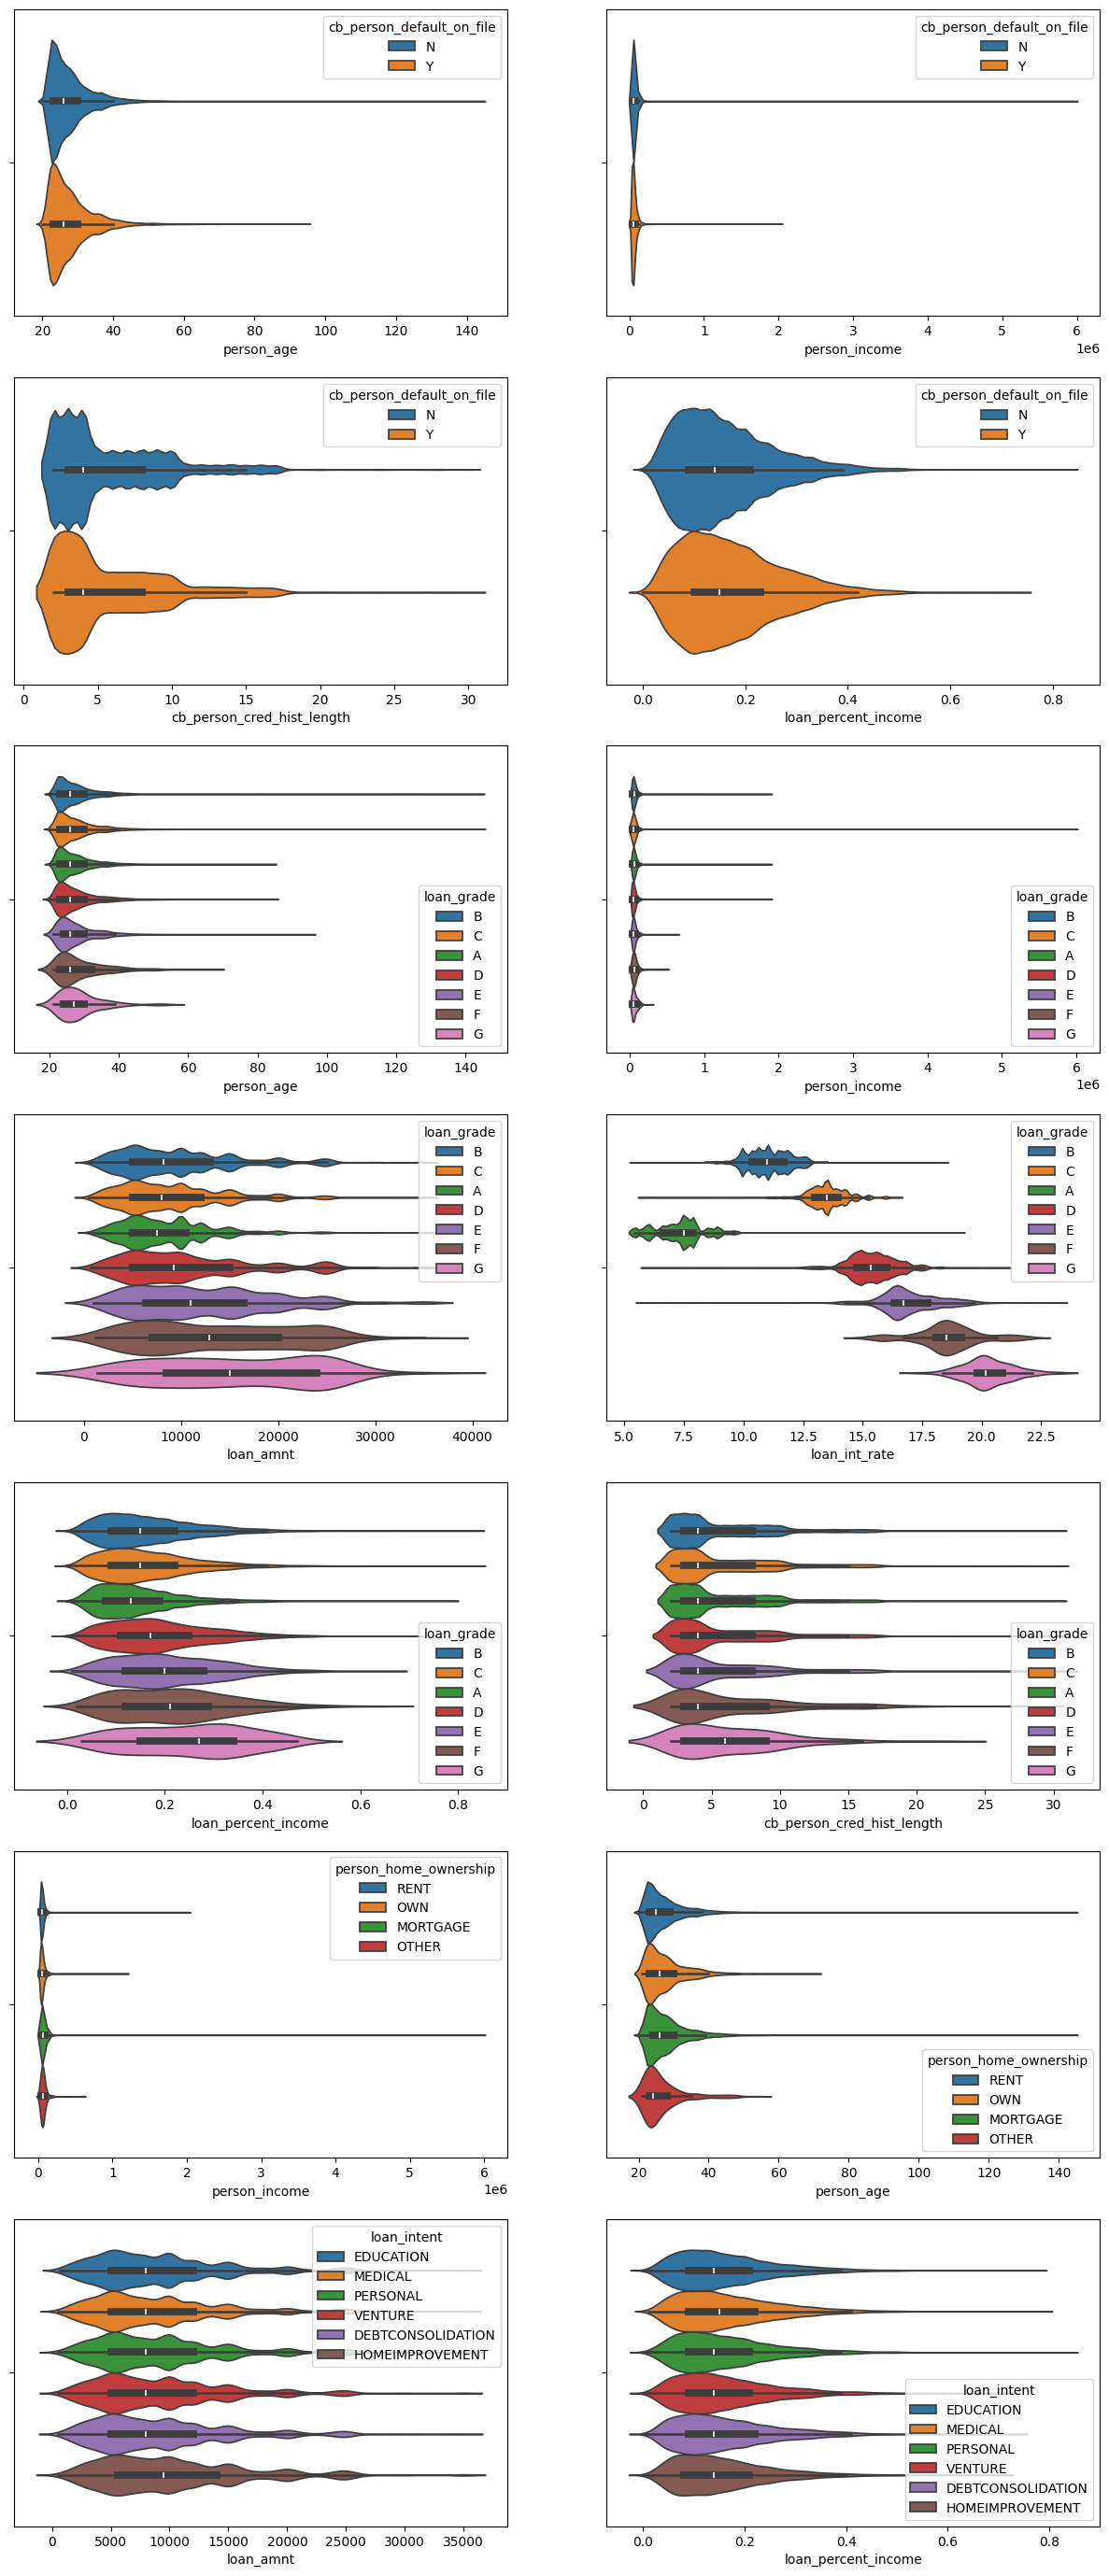

In [26]:
fig, axs = plt.subplots(figsize=(15,35),nrows=7, ncols=2)

sns.violinplot(data, x="person_age",hue='cb_person_default_on_file',ax=axs[0][0])
sns.violinplot(data, x="person_income",hue='cb_person_default_on_file',ax=axs[0][1])

sns.violinplot(data, x="cb_person_cred_hist_length",hue='cb_person_default_on_file',ax=axs[1][0])
sns.violinplot(data, x="loan_percent_income",hue='cb_person_default_on_file',ax=axs[1][1])

sns.violinplot(data, x="person_age",hue='loan_grade',ax=axs[2][0])
sns.violinplot(data, x="person_income",hue='loan_grade',ax=axs[2][1])

sns.violinplot(data, x="loan_amnt",hue='loan_grade',ax=axs[3][0])
sns.violinplot(data, x="loan_int_rate",hue='loan_grade',ax=axs[3][1])

sns.violinplot(data, x="loan_percent_income",hue='loan_grade',ax=axs[4][0])
sns.violinplot(data, x="cb_person_cred_hist_length",hue='loan_grade',ax=axs[4][1])

sns.violinplot(data, x="person_income",hue='person_home_ownership',ax=axs[5][0])
sns.violinplot(data, x="person_age",hue='person_home_ownership',ax=axs[5][1])

sns.violinplot(data, x="loan_amnt",hue='loan_intent',ax=axs[6][0])
sns.violinplot(data, x="loan_percent_income",hue='loan_intent',ax=axs[6][1])

<Axes: xlabel='cb_person_cred_hist_length', ylabel='Count'>

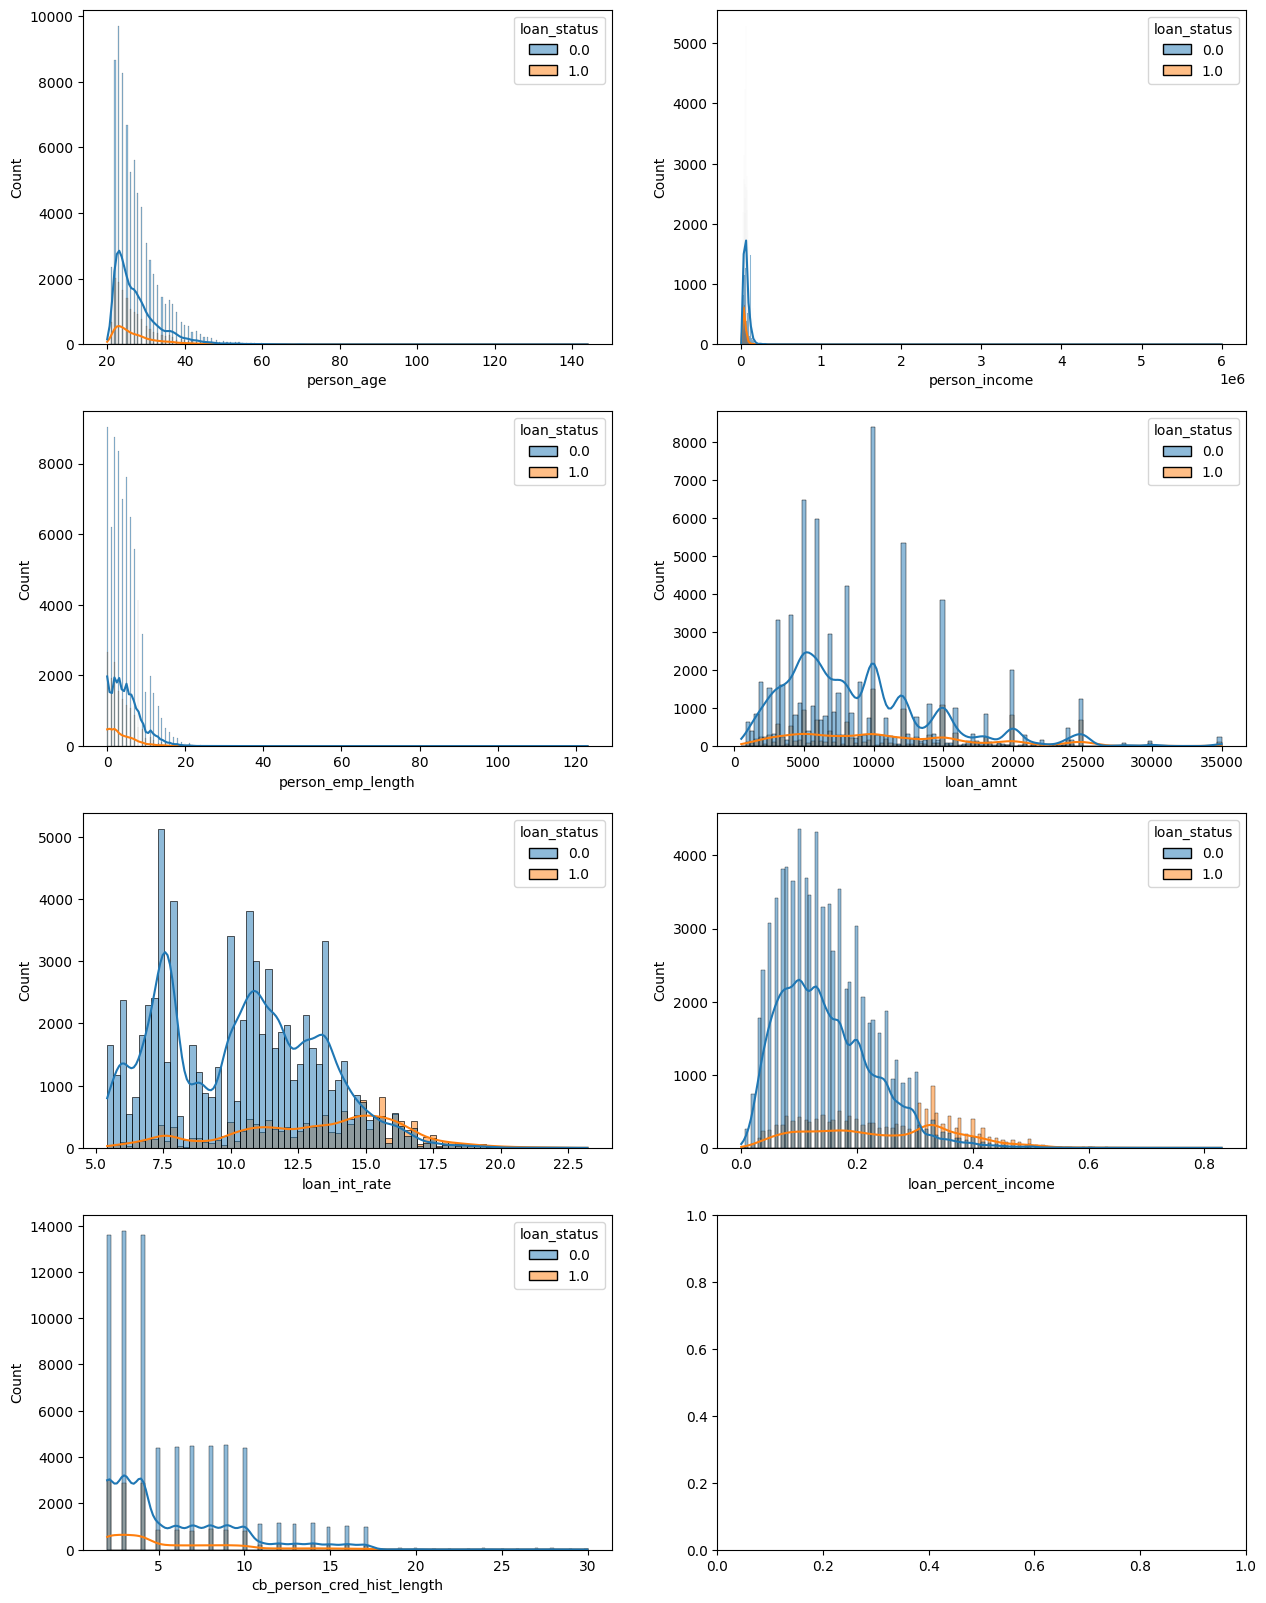

In [27]:
fig, axs = plt.subplots(figsize=(15,20),nrows=4, ncols=2)

sns.histplot(data, x="person_age",hue=target_column,ax=axs[0][0],kde=True)
sns.histplot(data, x="person_income",hue=target_column,ax=axs[0][1],kde=True)
sns.histplot(data, x="person_emp_length",hue=target_column,ax=axs[1][0],kde=True)
sns.histplot(data, x="loan_amnt",hue=target_column,ax=axs[1][1],kde=True)
sns.histplot(data, x="loan_int_rate",hue=target_column,ax=axs[2][0],kde=True)
sns.histplot(data, x="loan_percent_income",hue=target_column,ax=axs[2][1],kde=True)
sns.histplot(data, x="cb_person_cred_hist_length",hue=target_column,ax=axs[3][0],kde=True)

In [85]:
def loan_intent_impute(df):
    data = df.copy()

    data['loan_int_rate'] = data.groupby(by=["loan_grade"])['loan_int_rate'].transform(lambda x: x.fillna(x.mean()))
    data['loan_int_rate'] = data.groupby(by=["loan_intent"])['loan_int_rate'].transform(lambda x: x.fillna(x.mean()))
    data['loan_int_rate'] = data['loan_int_rate'].fillna(data['loan_int_rate'].mean()) # if any still left remaining after the group by operations

    return data

In [86]:
group_impute_transformer = FunctionTransformer(loan_intent_impute)
mode_impute_transformer = CategoricalImputer(variables=['person_emp_length'],imputation_method='frequent',ignore_format=True)

In [30]:
data_copy = group_impute_transformer.fit_transform(data_copy)
data_copy = mode_impute_transformer.fit_transform(data_copy)

In [31]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130324 entries, 0 to 130323
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          130324 non-null  int64  
 1   person_age                  130324 non-null  int64  
 2   person_income               130324 non-null  int64  
 3   person_home_ownership       130324 non-null  object 
 4   person_emp_length           130324 non-null  float64
 5   loan_intent                 130324 non-null  object 
 6   loan_grade                  130324 non-null  object 
 7   loan_amnt                   130324 non-null  int64  
 8   loan_int_rate               130324 non-null  float64
 9   loan_percent_income         130324 non-null  float64
 10  cb_person_default_on_file   130324 non-null  object 
 11  cb_person_cred_hist_length  130324 non-null  int64  
 12  loan_status                 91226 non-null   float64
 13  dataset       

In [32]:
def numeric_features(df):
    data = df.copy()

    data['income_reserve'] = data['person_income'] - data['loan_amnt']
    data['income_reserve'] = np.clip(data['income_reserve'], a_min=0, a_max=None)
    data['interest_amount_year'] = data['loan_amnt'] * (data['loan_int_rate'] / 100)
    data['earliest_age_work'] = data['person_age'] - data['person_emp_length']
    data['experience_age'] = data['person_emp_length'] / data['person_age']
    data['cred_hist_age'] = data['cb_person_cred_hist_length'] / data['person_age']
    data['cred_hist_exp'] = data['cb_person_cred_hist_length'] / (data['person_emp_length']+1)
    data['income_age'] = data['person_income'] / data['person_age']
    data['income_exp'] = data['person_income'] * data['person_emp_length']
    data['income_cred_hist'] = data['person_income'] * data['cb_person_cred_hist_length']
    
    return data

In [33]:
def binary_features(df):
    data = df.copy()

    data['no_work_experience'] = (data['person_emp_length'] == 0)
    data['is_loan_amnt_mulp_5K'] = (data['loan_amnt'] % 5000 == 0)
    income_reserve = data['person_income'] - data['loan_amnt']
    data['no_reserve_left'] = (income_reserve <= 0)
    
    for i in range(5000,40000,5000):
        data[f'is_loan_amnt_{i}'] = (data['loan_amnt'] == i)

    return data

In [34]:
numeric_ft_transformer = FunctionTransformer(numeric_features)
binary_ft_transformer = FunctionTransformer(binary_features)

In [35]:
data_copy = numeric_ft_transformer.fit_transform(data_copy)
data_copy = binary_ft_transformer.fit_transform(data_copy)

In [36]:
data_copy.head()

id  person_age  person_income person_home_ownership  person_emp_length loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   0          37          35000                  RENT                0.0   EDUCATION          B       6000           6.99                 0.17   
1   1          22          56000                   OWN                6.0     MEDICAL          C       4000           8.00                 0.07   
2   2          29          28800                   OWN                8.0    PERSONAL          A       6000           6.62                 0.21   
3   3          30          70000                  RENT               14.0     VENTURE          B      12000           7.68                 0.17   
4   4          22          60000                  RENT                2.0     MEDICAL          A       6000           7.51                 0.10   

  cb_person_default_on_file  cb_person_cred_hist_length  loan_status dataset  income_reserve  interest_amount_year  earliest_age_work  \
0                         N                          14          0.0   train           29000                 419.4               37.0   
1                         N                           2          0.0   train           52000                 320.0               16.0   
2                         N                          10          0.0   train           22800                 397.2               21.0   
3                         N                           5          0.0   train           58000                 921.6               16.0   
4                         N                           3          0.0   train           54000                 450.6               20.0   

   experience_age  cred_hist_age  cred_hist_exp   income_age  income_exp  income_cred_hist  no_work_experience  is_loan_amnt_mulp_5K  \
0        0.000000       0.378378      14.000000   945.945946         0.0            490000                True                 False   
1        0.272727       0.090909       0.285714  2545.454545    336000.0            112000               False                 False   
2        0.275862       0.344828       1.111111   993.103448    230400.0            288000               False                 False   
3        0.466667       0.166667       0.333333  2333.333333    980000.0            350000               False                 False   
4        0.090909       0.136364       1.000000  2727.272727    120000.0            180000               False                 False   

   no_reserve_left  is_loan_amnt_5000  is_loan_amnt_10000  is_loan_amnt_15000  is_loan_amnt_20000  is_loan_amnt_25000  is_loan_amnt_30000  \
0            False              False               False               False               False               False               False   
1            False              False               False               False               False               False               False   
2            False              False               False               False               False               False               False   
3            False              False               False               False               False               False               False   
4            False              False               False               False               False               False               False   

   is_loan_amnt_35000  
0               False  
1               False  
2               False  
3               False  
4               False

<Axes: xlabel='is_loan_amnt_mulp_5K', ylabel='count'>

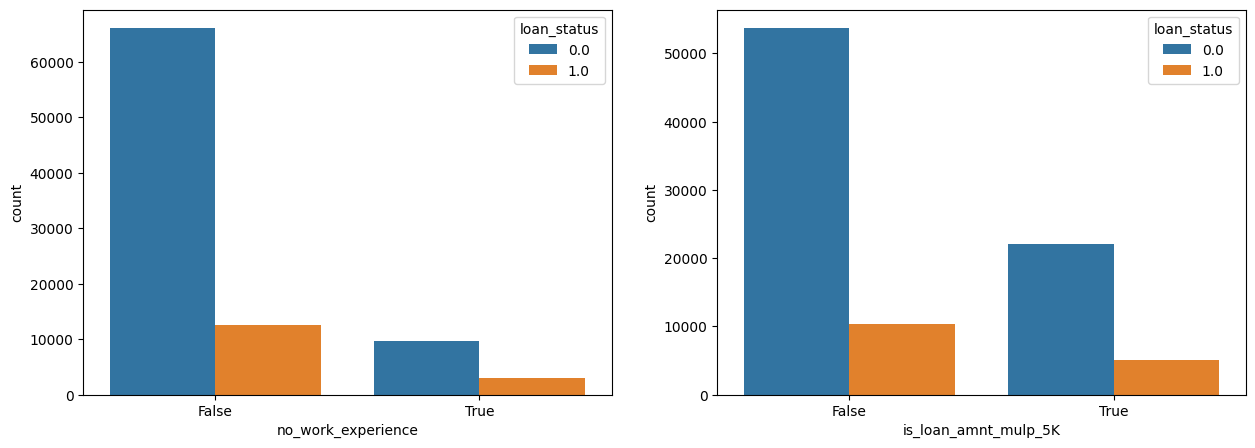

In [37]:
fig, axs = plt.subplots(figsize=(15,5),nrows=1, ncols=2)

sns.countplot(data_copy, x="no_work_experience", hue="loan_status",ax=axs[0])
sns.countplot(data_copy, x="is_loan_amnt_mulp_5K", hue="loan_status",ax=axs[1])

<Axes: xlabel='income_cred_hist', ylabel='Count'>

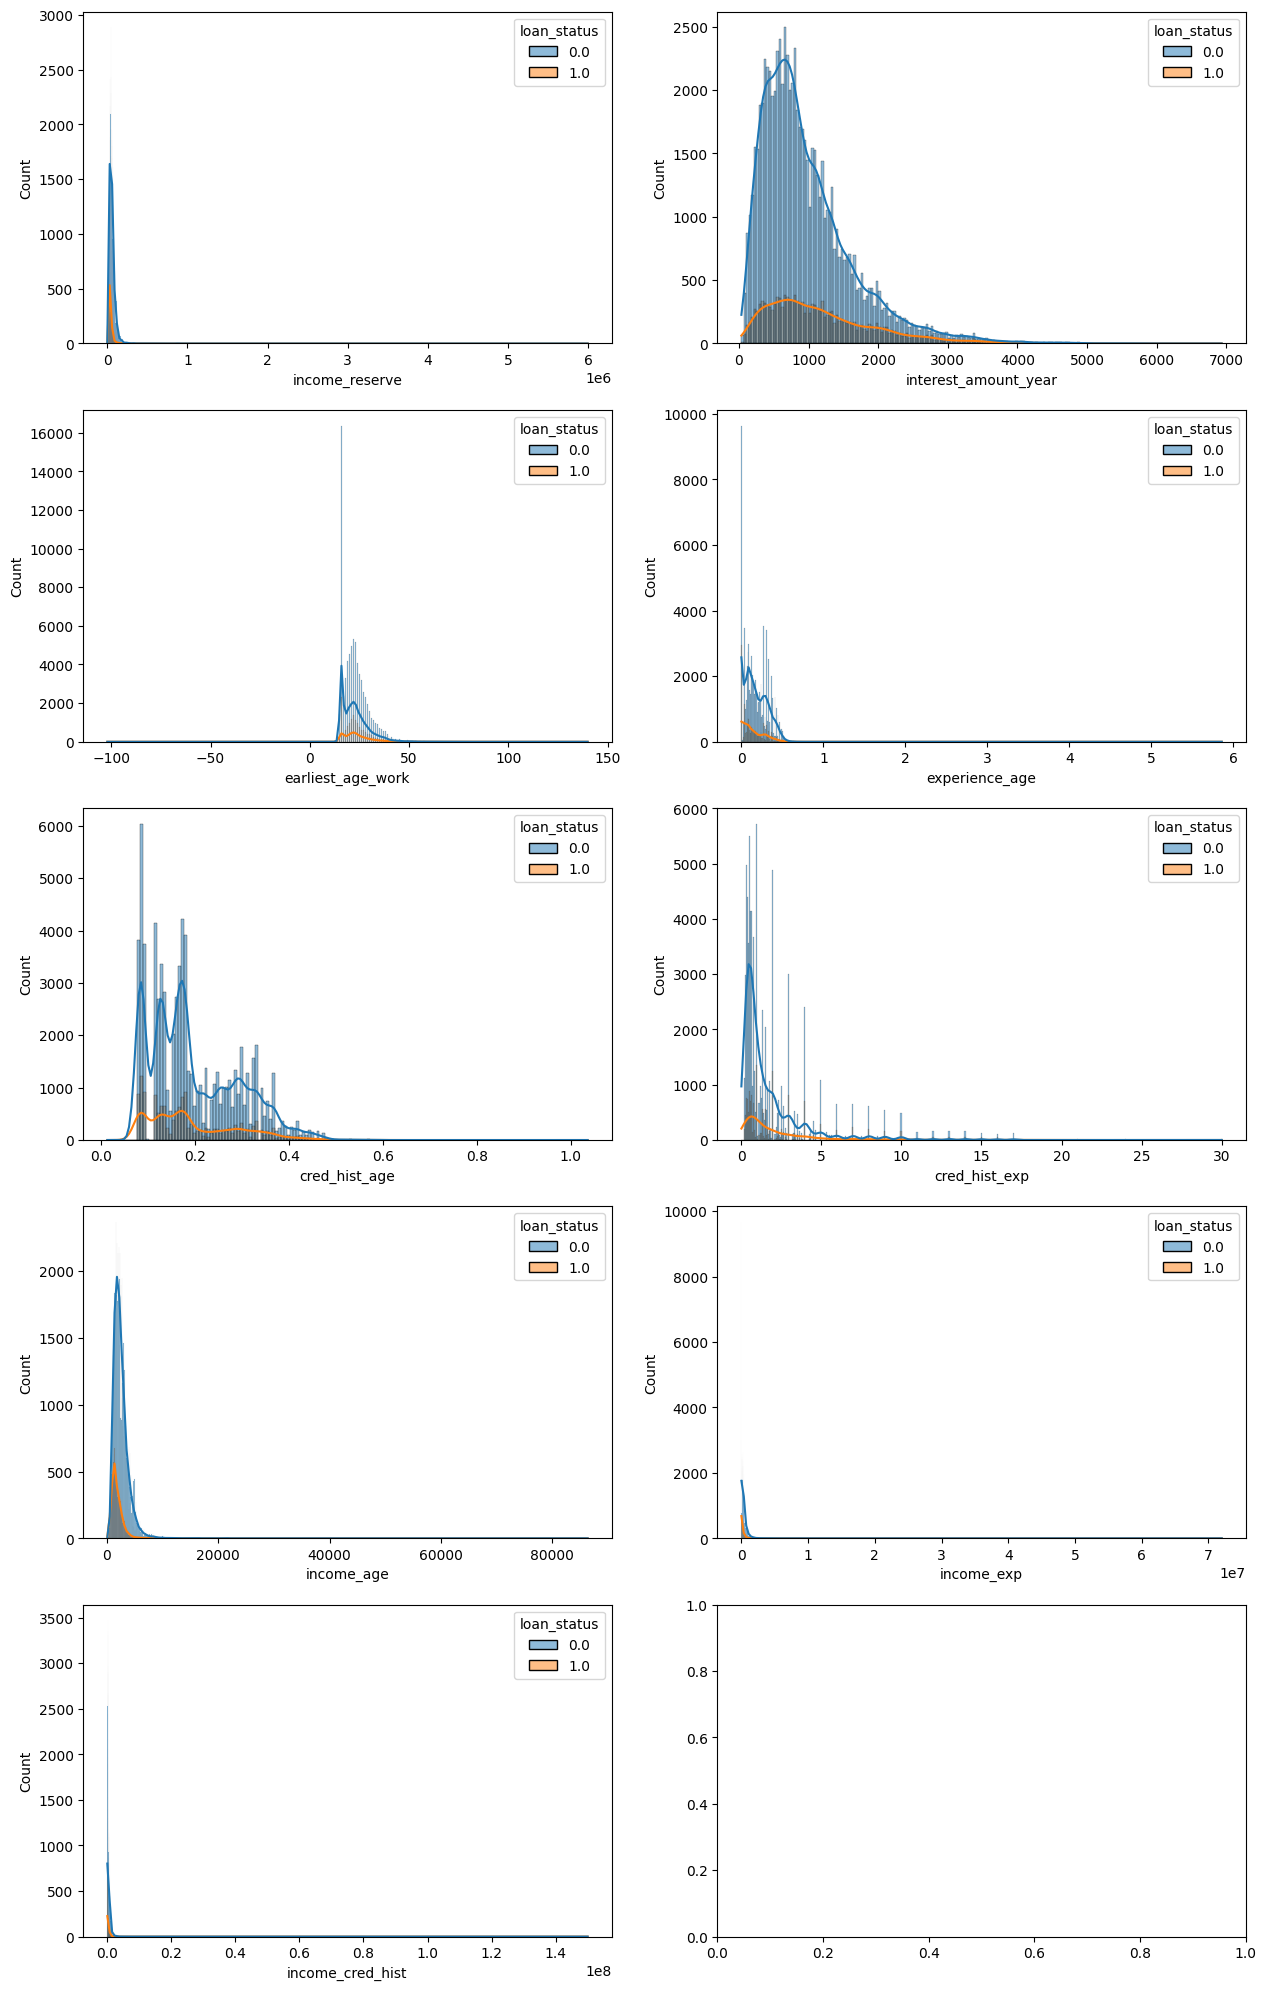

In [38]:
fig, axs = plt.subplots(figsize=(15,25),nrows=5, ncols=2)

sns.histplot(data_copy, x="income_reserve",hue=target_column,ax=axs[0][0],kde=True)
sns.histplot(data_copy, x="interest_amount_year",hue=target_column,ax=axs[0][1],kde=True)
sns.histplot(data_copy, x="earliest_age_work",hue=target_column,ax=axs[1][0],kde=True)
sns.histplot(data_copy, x="experience_age",hue=target_column,ax=axs[1][1],kde=True)
sns.histplot(data_copy, x="cred_hist_age",hue=target_column,ax=axs[2][0],kde=True)
sns.histplot(data_copy, x="cred_hist_exp",hue=target_column,ax=axs[2][1],kde=True)
sns.histplot(data_copy, x="income_age",hue=target_column,ax=axs[3][0],kde=True)
sns.histplot(data_copy, x="income_exp",hue=target_column,ax=axs[3][1],kde=True)
sns.histplot(data_copy, x="income_cred_hist",hue=target_column,ax=axs[4][0],kde=True)

<Axes: xlabel='income_cred_hist'>

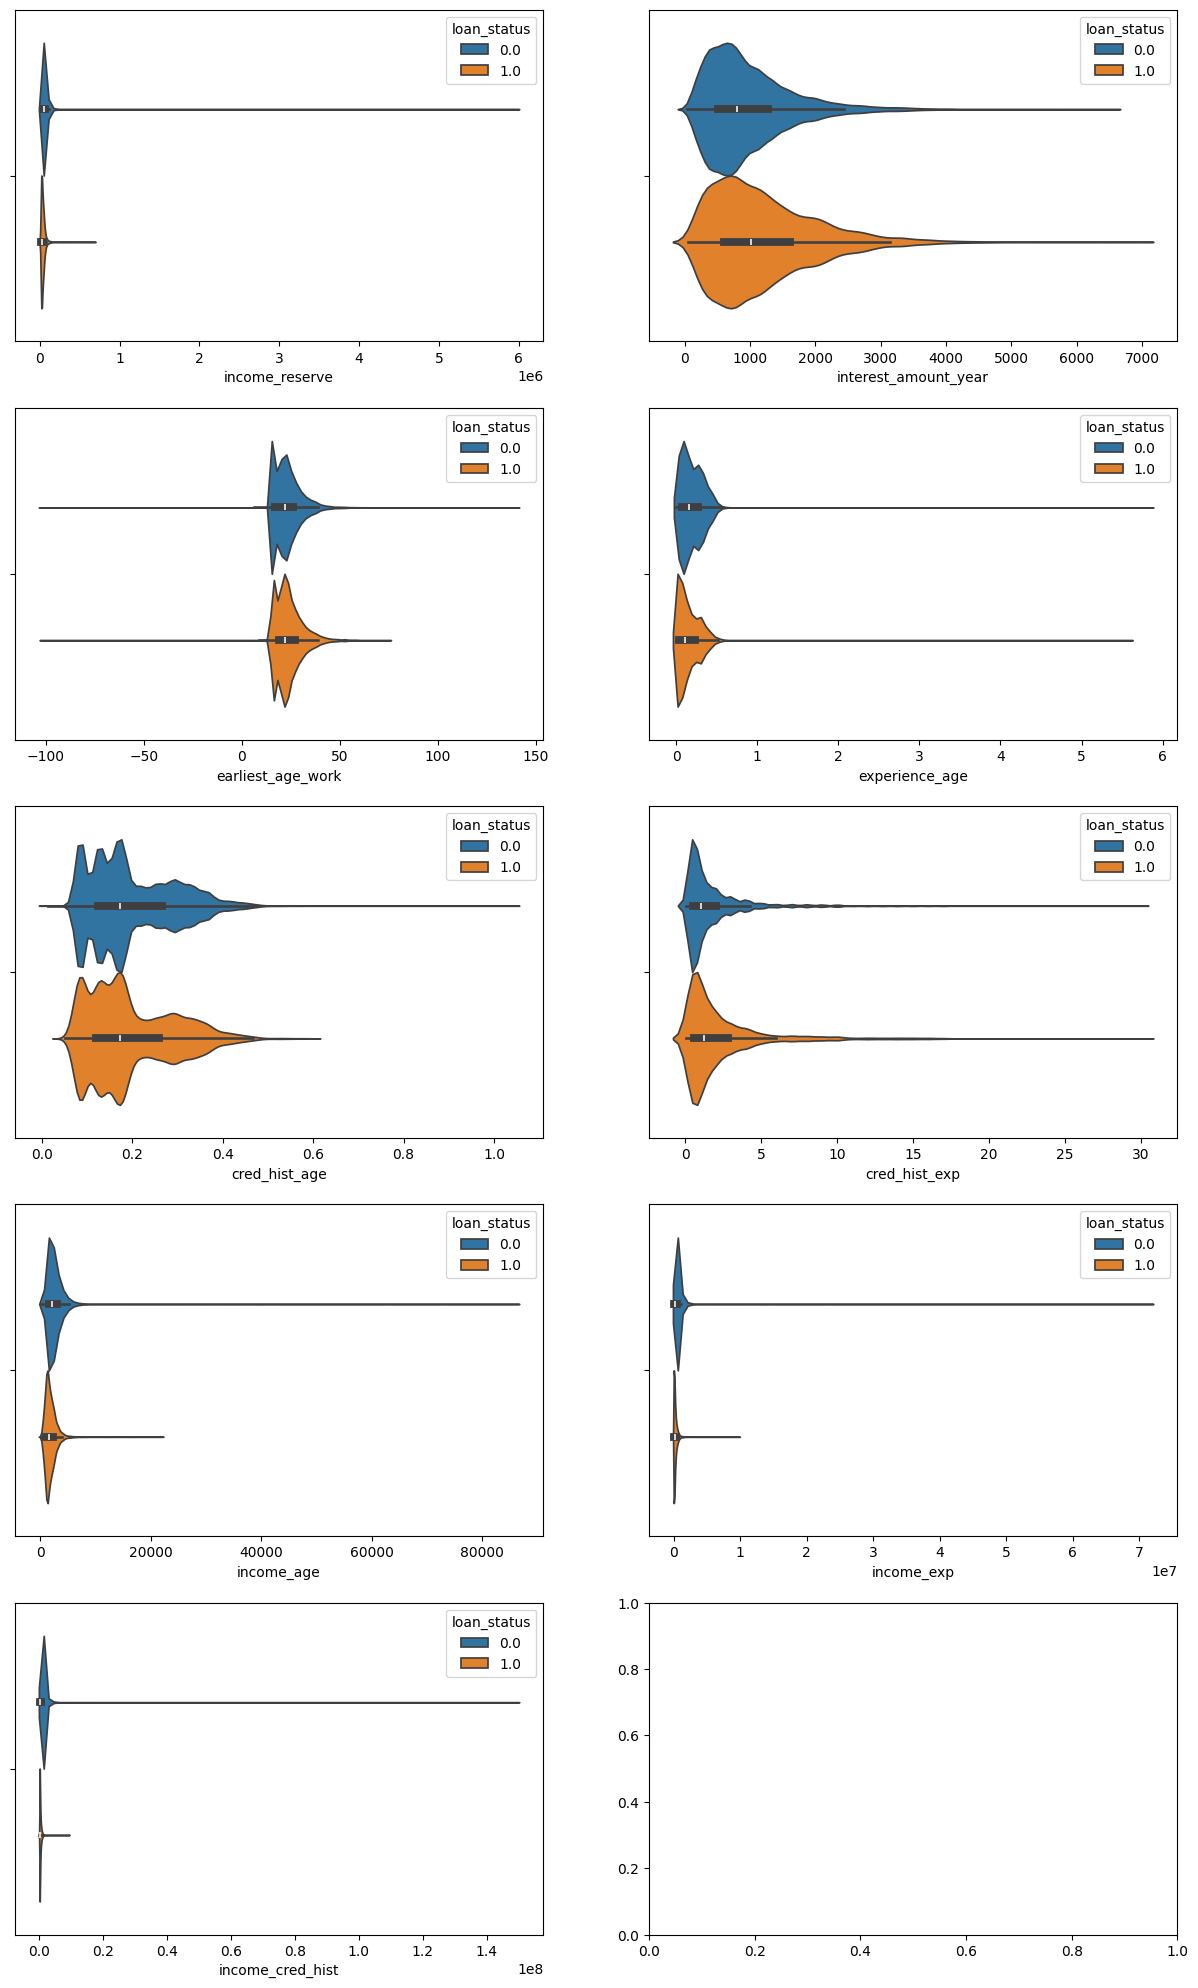

In [39]:
fig, axs = plt.subplots(figsize=(15,25),nrows=5, ncols=2)

sns.violinplot(data_copy, x="income_reserve",hue=target_column,ax=axs[0][0])
sns.violinplot(data_copy, x="interest_amount_year",hue=target_column,ax=axs[0][1])
sns.violinplot(data_copy, x="earliest_age_work",hue=target_column,ax=axs[1][0])
sns.violinplot(data_copy, x="experience_age",hue=target_column,ax=axs[1][1])
sns.violinplot(data_copy, x="cred_hist_age",hue=target_column,ax=axs[2][0])
sns.violinplot(data_copy, x="cred_hist_exp",hue=target_column,ax=axs[2][1])
sns.violinplot(data_copy, x="income_age",hue=target_column,ax=axs[3][0])
sns.violinplot(data_copy, x="income_exp",hue=target_column,ax=axs[3][1])
sns.violinplot(data_copy, x="income_cred_hist",hue=target_column,ax=axs[4][0])

In [40]:
def drop_outliers(df):
    data = df.copy()

    data = data[data['person_age'] <= 100] # remove rows past 100 years old
    data = data[data['person_income'] <= 3e6] # remove income past 3 million rupees
    data = data[data['person_emp_length'] <= 60] # remove years exp past 60 years

    data = data.reset_index(drop=True)

    return data

In [41]:
outlier_remover = FunctionTransformer(drop_outliers)

In [42]:
data_no_outlier = outlier_remover.fit_transform(data_copy)

<Axes: xlabel='person_income', ylabel='loan_percent_income'>

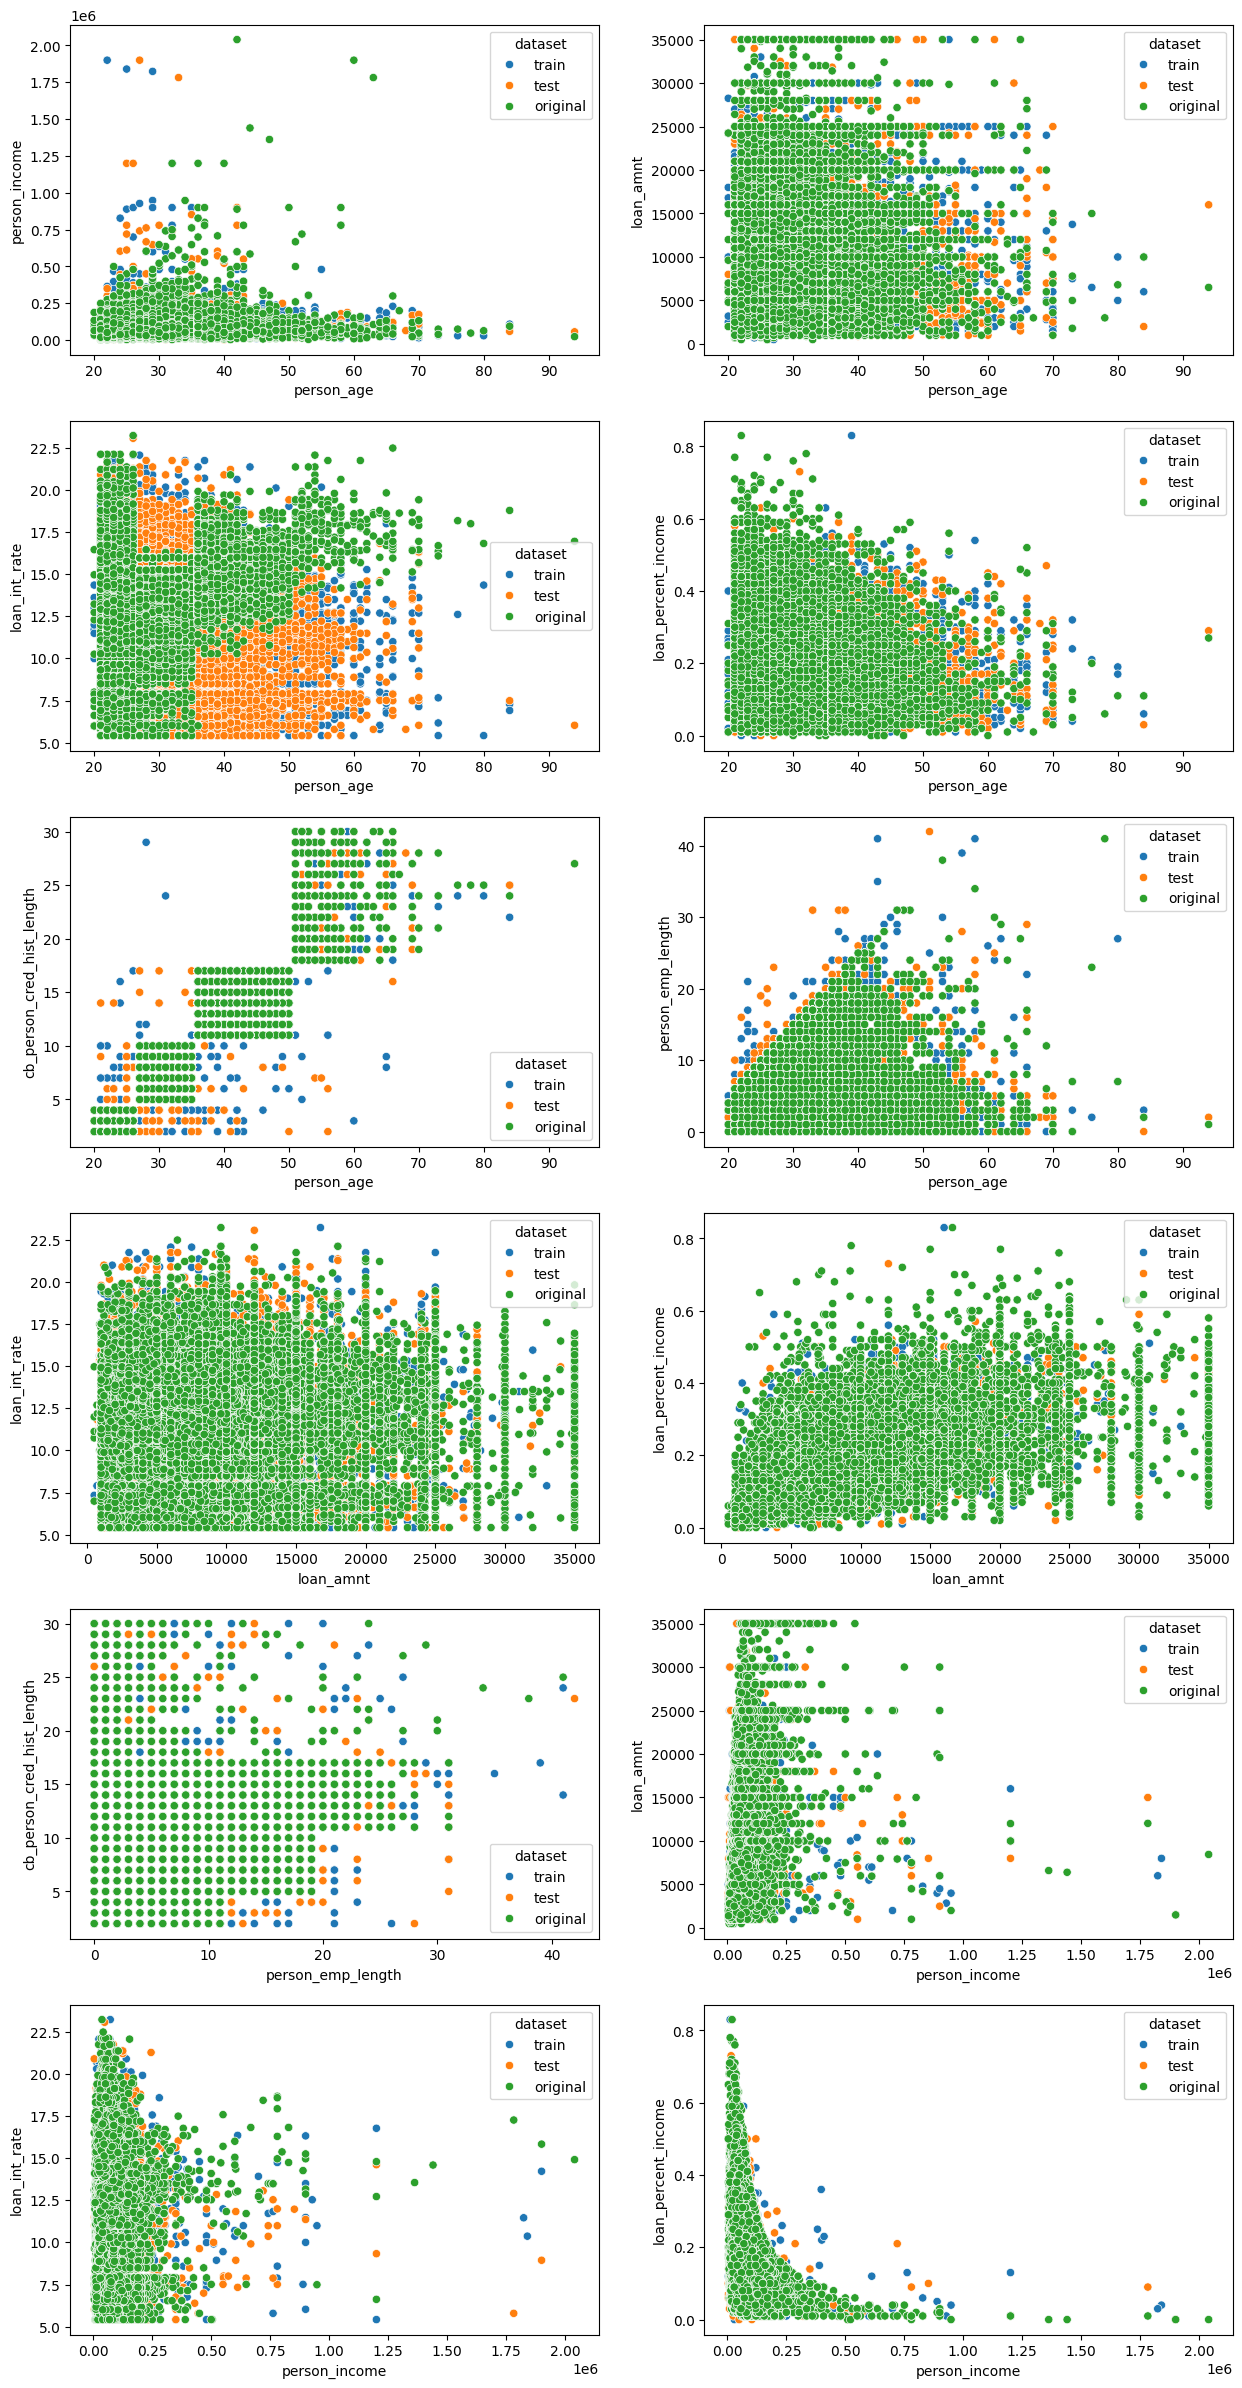

In [43]:
fig, axs = plt.subplots(figsize=(15,30),nrows=6, ncols=2)

sns.scatterplot(data_no_outlier,x="person_age",y="person_income",hue="dataset",ax=axs[0][0])
sns.scatterplot(data_no_outlier,x="person_age",y="loan_amnt",hue="dataset",ax=axs[0][1])
sns.scatterplot(data_no_outlier,x="person_age",y="loan_int_rate",hue="dataset",ax=axs[1][0])
sns.scatterplot(data_no_outlier,x="person_age",y="loan_percent_income",hue="dataset",ax=axs[1][1])
sns.scatterplot(data_no_outlier,x="person_age",y="cb_person_cred_hist_length",hue="dataset",ax=axs[2][0])
sns.scatterplot(data_no_outlier,x="person_age",y="person_emp_length",hue="dataset",ax=axs[2][1])
sns.scatterplot(data_no_outlier,x="loan_amnt",y="loan_int_rate",hue="dataset",ax=axs[3][0])
sns.scatterplot(data_no_outlier,x="loan_amnt",y="loan_percent_income",hue="dataset",ax=axs[3][1])
sns.scatterplot(data_no_outlier,x="person_emp_length",y="cb_person_cred_hist_length",hue="dataset",ax=axs[4][0])
sns.scatterplot(data_no_outlier,x="person_income",y="loan_amnt",hue="dataset",ax=axs[4][1])
sns.scatterplot(data_no_outlier,x="person_income",y="loan_int_rate",hue="dataset",ax=axs[5][0])
sns.scatterplot(data_no_outlier,x="person_income",y="loan_percent_income",hue="dataset",ax=axs[5][1])

<Axes: xlabel='loan_percent_income'>

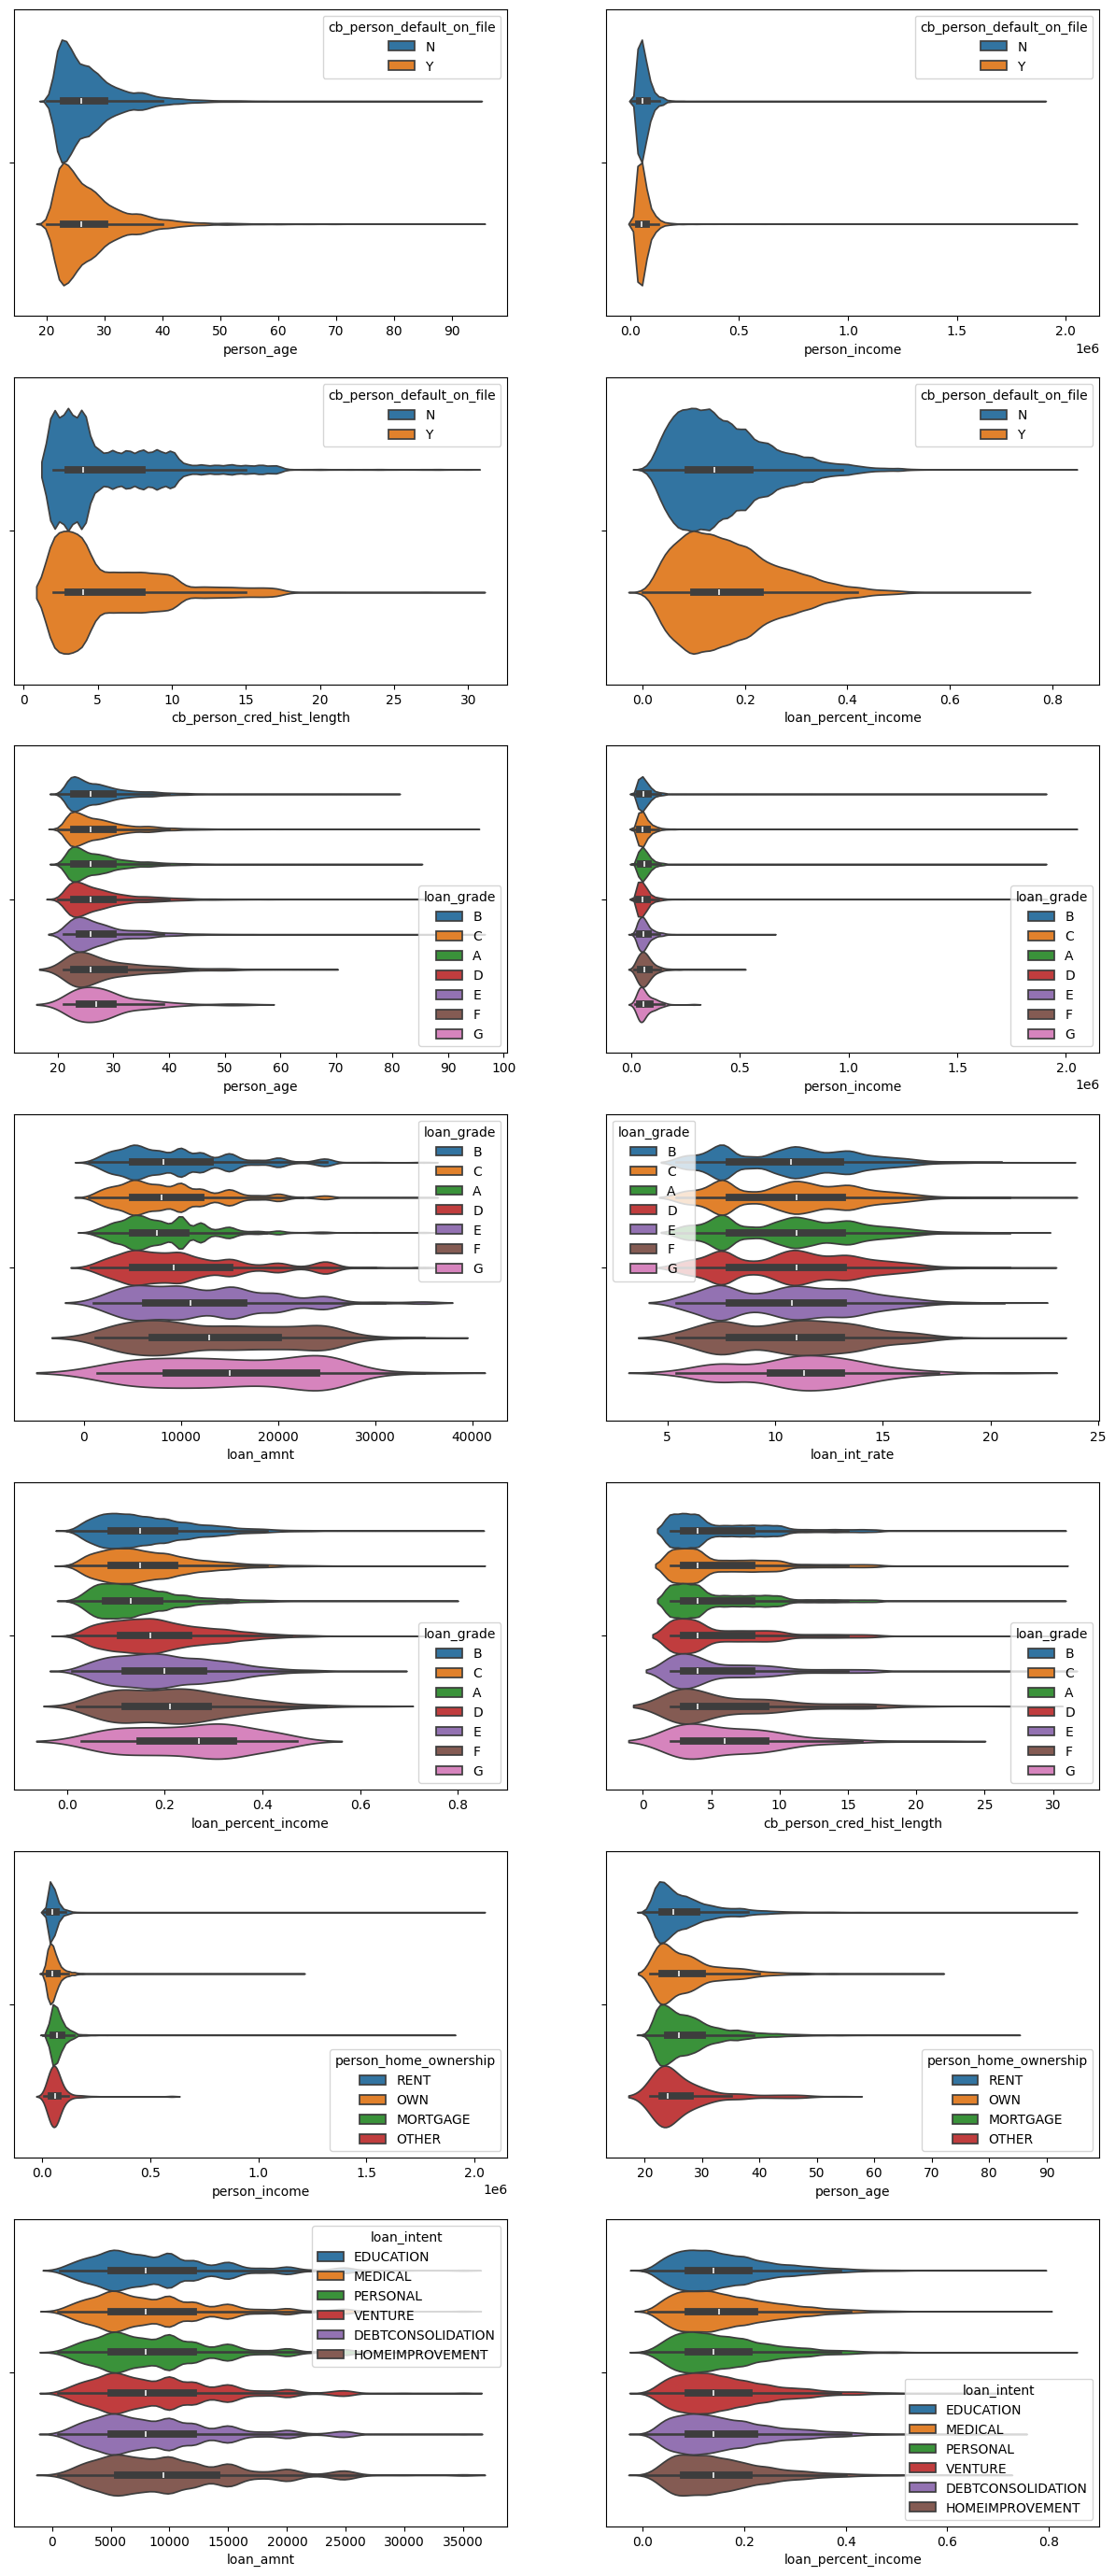

In [44]:
fig, axs = plt.subplots(figsize=(15,35),nrows=7, ncols=2)

sns.violinplot(data_no_outlier, x="person_age",hue='cb_person_default_on_file',ax=axs[0][0])
sns.violinplot(data_no_outlier, x="person_income",hue='cb_person_default_on_file',ax=axs[0][1])

sns.violinplot(data_no_outlier, x="cb_person_cred_hist_length",hue='cb_person_default_on_file',ax=axs[1][0])
sns.violinplot(data_no_outlier, x="loan_percent_income",hue='cb_person_default_on_file',ax=axs[1][1])

sns.violinplot(data_no_outlier, x="person_age",hue='loan_grade',ax=axs[2][0])
sns.violinplot(data_no_outlier, x="person_income",hue='loan_grade',ax=axs[2][1])

sns.violinplot(data_no_outlier, x="loan_amnt",hue='loan_grade',ax=axs[3][0])
sns.violinplot(data_no_outlier, x="loan_int_rate",hue='loan_grade',ax=axs[3][1])

sns.violinplot(data_no_outlier, x="loan_percent_income",hue='loan_grade',ax=axs[4][0])
sns.violinplot(data_no_outlier, x="cb_person_cred_hist_length",hue='loan_grade',ax=axs[4][1])

sns.violinplot(data_no_outlier, x="person_income",hue='person_home_ownership',ax=axs[5][0])
sns.violinplot(data_no_outlier, x="person_age",hue='person_home_ownership',ax=axs[5][1])

sns.violinplot(data_no_outlier, x="loan_amnt",hue='loan_intent',ax=axs[6][0])
sns.violinplot(data_no_outlier, x="loan_percent_income",hue='loan_intent',ax=axs[6][1])

<Axes: xlabel='cb_person_cred_hist_length', ylabel='Count'>

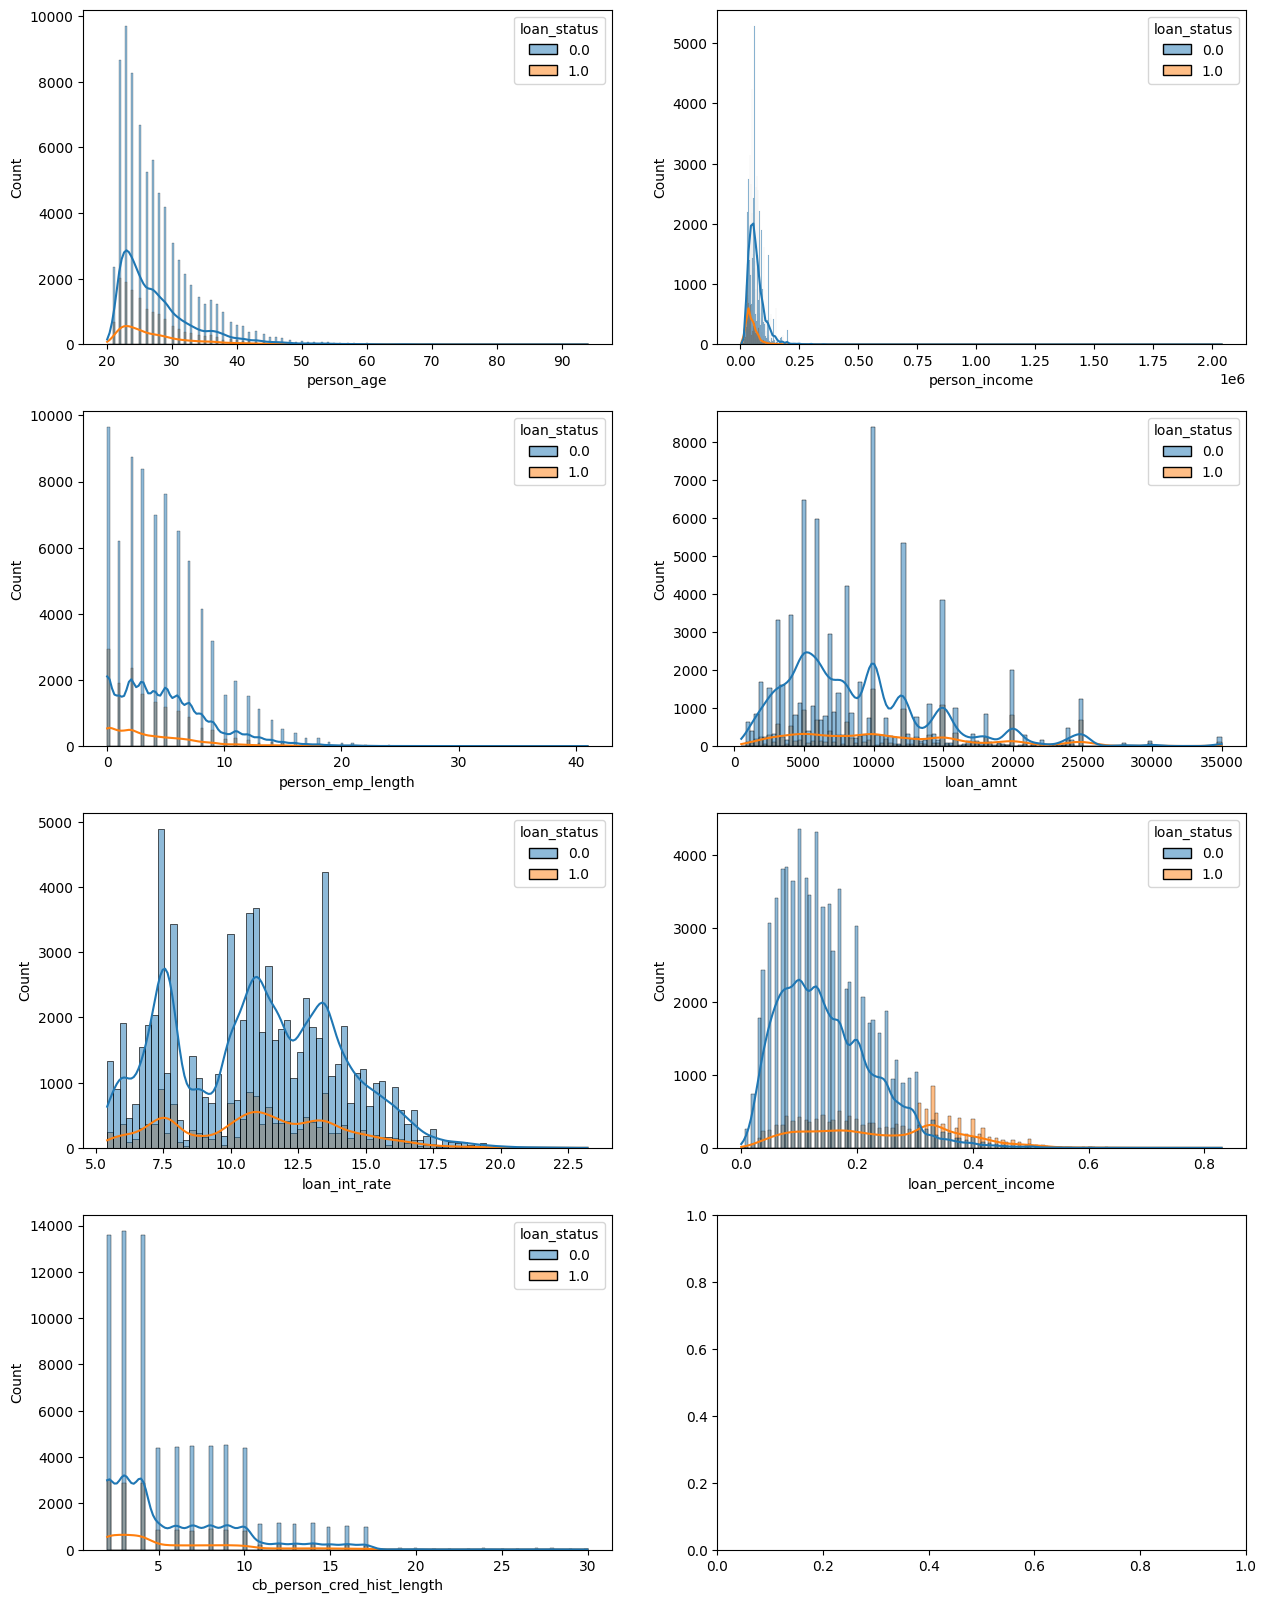

In [45]:
fig, axs = plt.subplots(figsize=(15,20),nrows=4, ncols=2)

sns.histplot(data_no_outlier, x="person_age",hue=target_column,ax=axs[0][0],kde=True)
sns.histplot(data_no_outlier, x="person_income",hue=target_column,ax=axs[0][1],kde=True)
sns.histplot(data_no_outlier, x="person_emp_length",hue=target_column,ax=axs[1][0],kde=True)
sns.histplot(data_no_outlier, x="loan_amnt",hue=target_column,ax=axs[1][1],kde=True)
sns.histplot(data_no_outlier, x="loan_int_rate",hue=target_column,ax=axs[2][0],kde=True)
sns.histplot(data_no_outlier, x="loan_percent_income",hue=target_column,ax=axs[2][1],kde=True)
sns.histplot(data_no_outlier, x="cb_person_cred_hist_length",hue=target_column,ax=axs[3][0],kde=True)

<Axes: xlabel='income_cred_hist', ylabel='Count'>

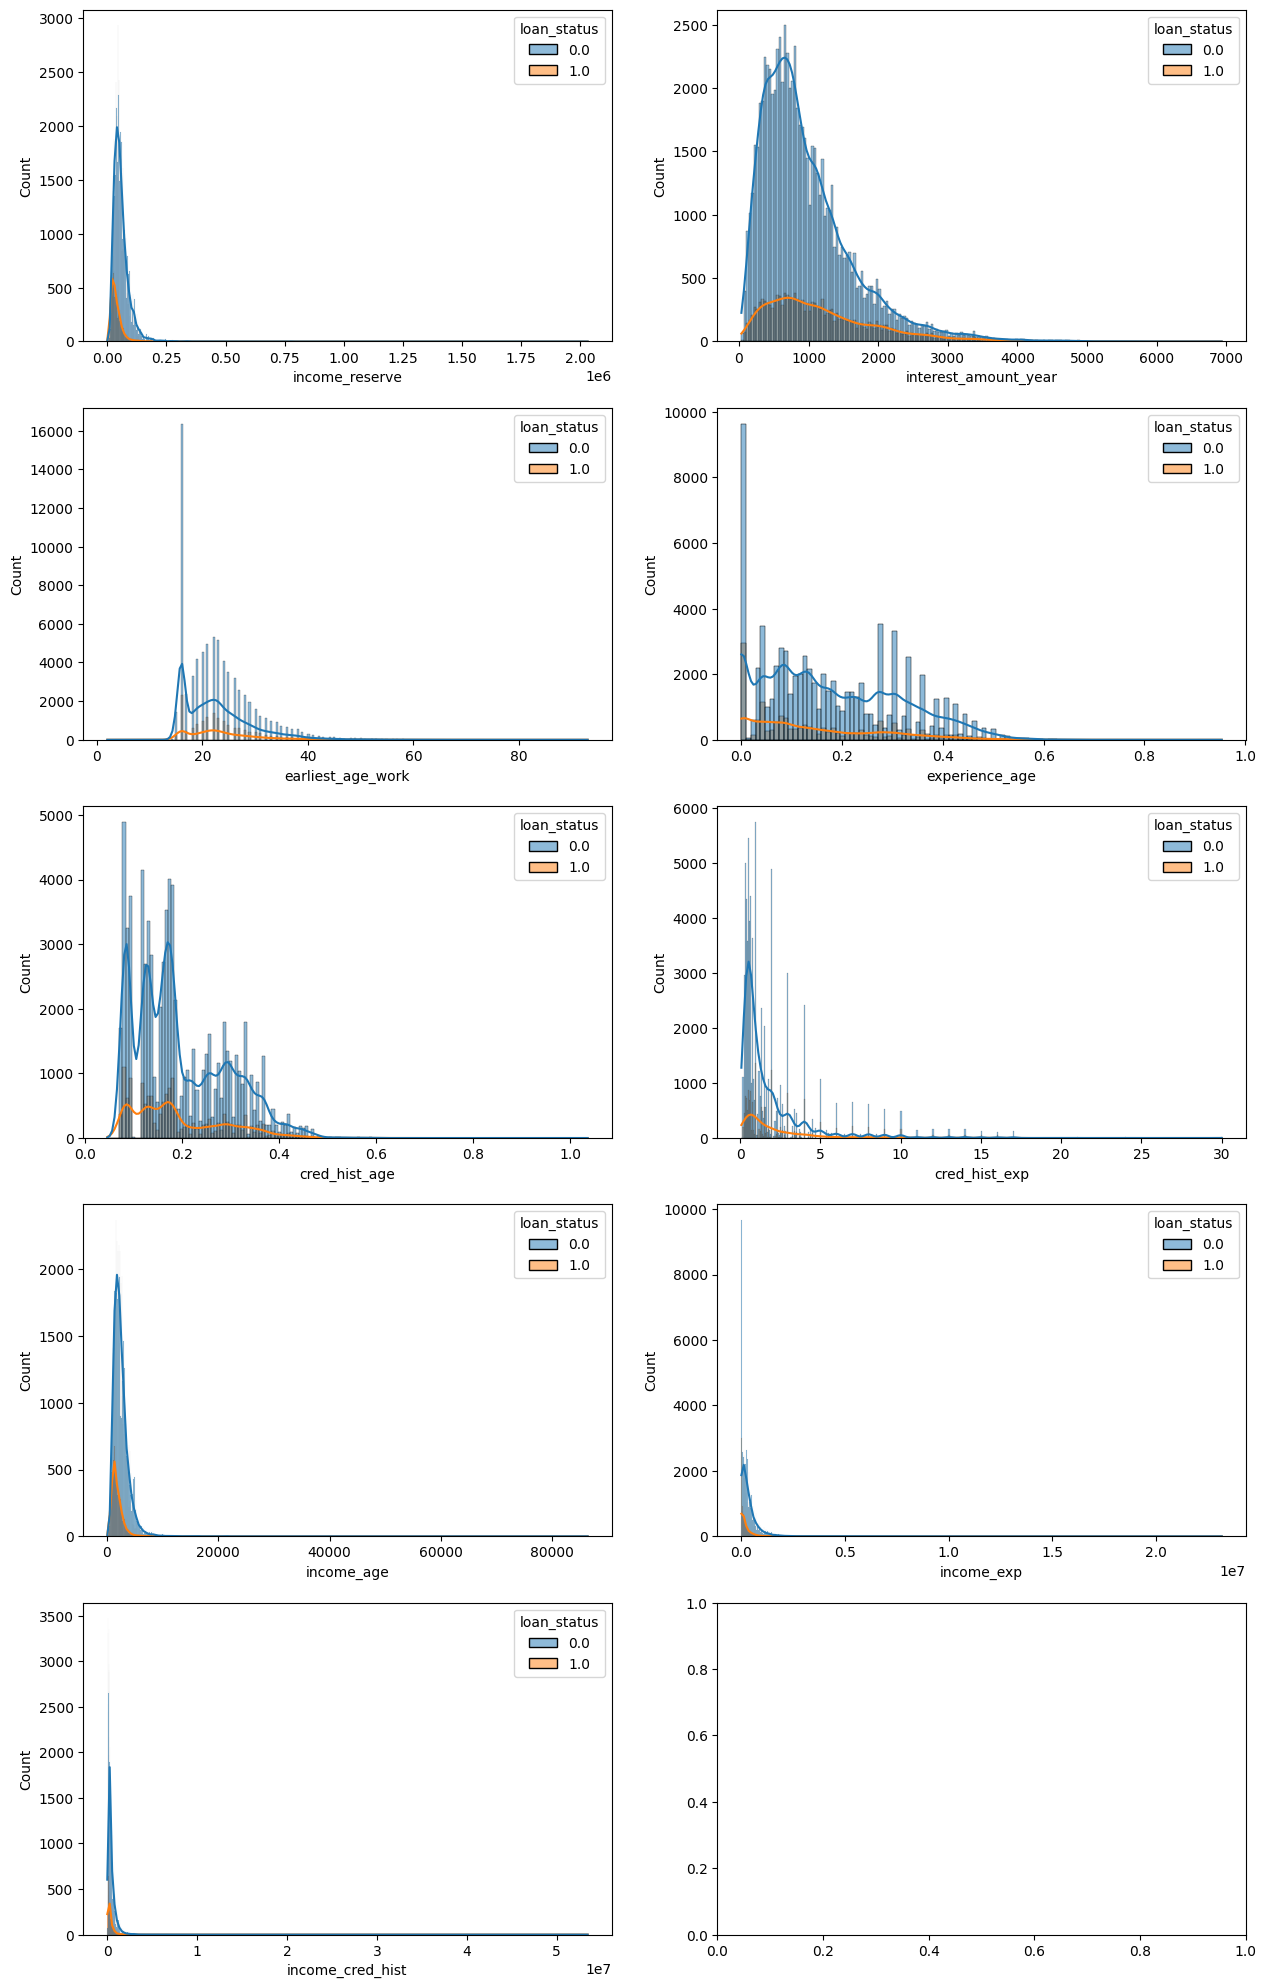

In [46]:
fig, axs = plt.subplots(figsize=(15,25),nrows=5, ncols=2)

sns.histplot(data_no_outlier, x="income_reserve",hue=target_column,ax=axs[0][0],kde=True)
sns.histplot(data_no_outlier, x="interest_amount_year",hue=target_column,ax=axs[0][1],kde=True)
sns.histplot(data_no_outlier, x="earliest_age_work",hue=target_column,ax=axs[1][0],kde=True)
sns.histplot(data_no_outlier, x="experience_age",hue=target_column,ax=axs[1][1],kde=True)
sns.histplot(data_no_outlier, x="cred_hist_age",hue=target_column,ax=axs[2][0],kde=True)
sns.histplot(data_no_outlier, x="cred_hist_exp",hue=target_column,ax=axs[2][1],kde=True)
sns.histplot(data_no_outlier, x="income_age",hue=target_column,ax=axs[3][0],kde=True)
sns.histplot(data_no_outlier, x="income_exp",hue=target_column,ax=axs[3][1],kde=True)
sns.histplot(data_no_outlier, x="income_cred_hist",hue=target_column,ax=axs[4][0],kde=True)

<Axes: xlabel='income_cred_hist'>

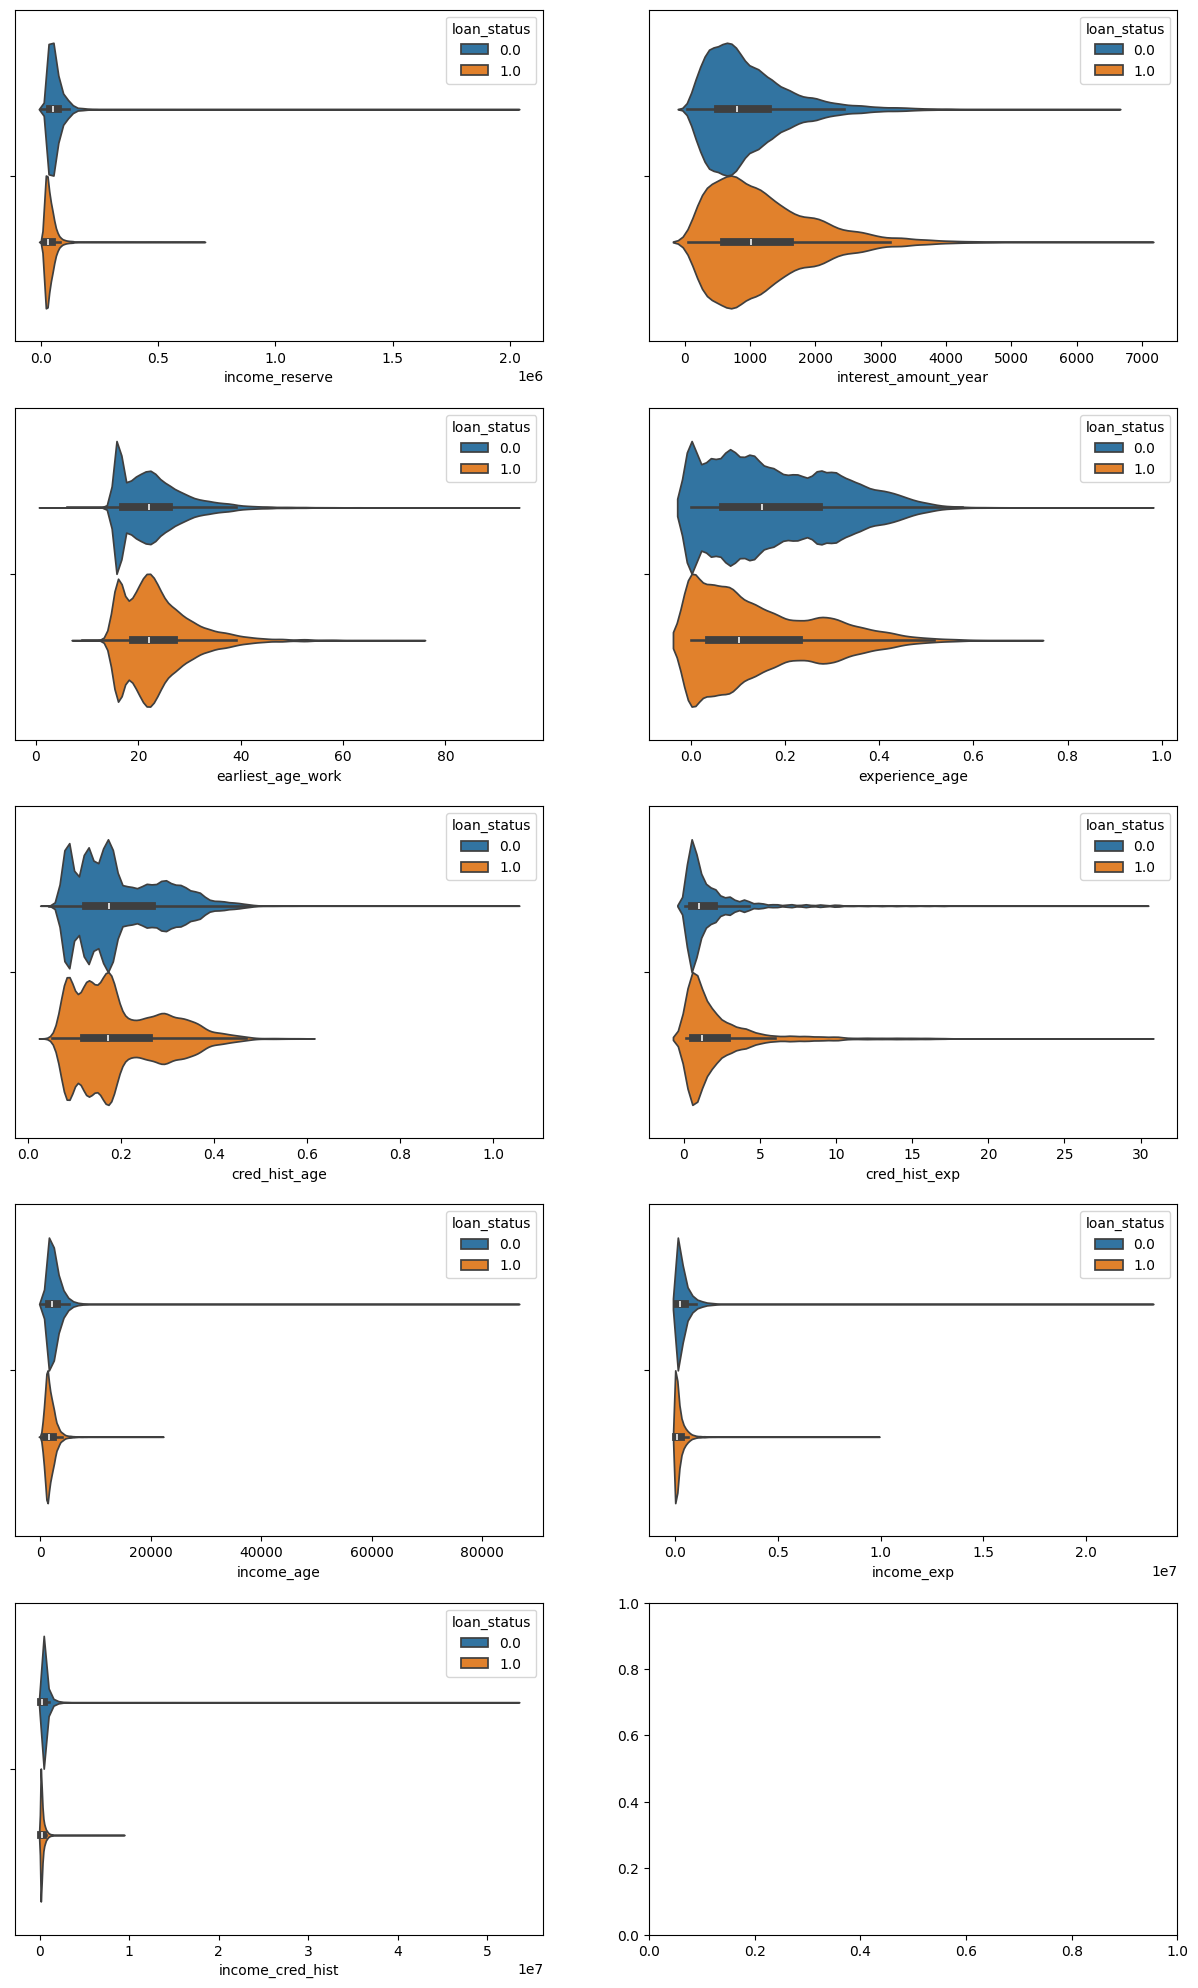

In [47]:
fig, axs = plt.subplots(figsize=(15,25),nrows=5, ncols=2)

sns.violinplot(data_no_outlier, x="income_reserve",hue=target_column,ax=axs[0][0])
sns.violinplot(data_no_outlier, x="interest_amount_year",hue=target_column,ax=axs[0][1])
sns.violinplot(data_no_outlier, x="earliest_age_work",hue=target_column,ax=axs[1][0])
sns.violinplot(data_no_outlier, x="experience_age",hue=target_column,ax=axs[1][1])
sns.violinplot(data_no_outlier, x="cred_hist_age",hue=target_column,ax=axs[2][0])
sns.violinplot(data_no_outlier, x="cred_hist_exp",hue=target_column,ax=axs[2][1])
sns.violinplot(data_no_outlier, x="income_age",hue=target_column,ax=axs[3][0])
sns.violinplot(data_no_outlier, x="income_exp",hue=target_column,ax=axs[3][1])
sns.violinplot(data_no_outlier, x="income_cred_hist",hue=target_column,ax=axs[4][0])

In [48]:
data_no_outlier.head()

id  person_age  person_income person_home_ownership  person_emp_length loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   0          37          35000                  RENT                0.0   EDUCATION          B       6000           6.99                 0.17   
1   1          22          56000                   OWN                6.0     MEDICAL          C       4000           8.00                 0.07   
2   2          29          28800                   OWN                8.0    PERSONAL          A       6000           6.62                 0.21   
3   3          30          70000                  RENT               14.0     VENTURE          B      12000           7.68                 0.17   
4   4          22          60000                  RENT                2.0     MEDICAL          A       6000           7.51                 0.10   

  cb_person_default_on_file  cb_person_cred_hist_length  loan_status dataset  income_reserve  interest_amount_year  earliest_age_work  \
0                         N                          14          0.0   train           29000                 419.4               37.0   
1                         N                           2          0.0   train           52000                 320.0               16.0   
2                         N                          10          0.0   train           22800                 397.2               21.0   
3                         N                           5          0.0   train           58000                 921.6               16.0   
4                         N                           3          0.0   train           54000                 450.6               20.0   

   experience_age  cred_hist_age  cred_hist_exp   income_age  income_exp  income_cred_hist  no_work_experience  is_loan_amnt_mulp_5K  \
0        0.000000       0.378378      14.000000   945.945946         0.0            490000                True                 False   
1        0.272727       0.090909       0.285714  2545.454545    336000.0            112000               False                 False   
2        0.275862       0.344828       1.111111   993.103448    230400.0            288000               False                 False   
3        0.466667       0.166667       0.333333  2333.333333    980000.0            350000               False                 False   
4        0.090909       0.136364       1.000000  2727.272727    120000.0            180000               False                 False   

   no_reserve_left  is_loan_amnt_5000  is_loan_amnt_10000  is_loan_amnt_15000  is_loan_amnt_20000  is_loan_amnt_25000  is_loan_amnt_30000  \
0            False              False               False               False               False               False               False   
1            False              False               False               False               False               False               False   
2            False              False               False               False               False               False               False   
3            False              False               False               False               False               False               False   
4            False              False               False               False               False               False               False   

   is_loan_amnt_35000  
0               False  
1               False  
2               False  
3               False  
4               False

In [49]:
data_no_outlier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130314 entries, 0 to 130313
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          130314 non-null  int64  
 1   person_age                  130314 non-null  int64  
 2   person_income               130314 non-null  int64  
 3   person_home_ownership       130314 non-null  object 
 4   person_emp_length           130314 non-null  float64
 5   loan_intent                 130314 non-null  object 
 6   loan_grade                  130314 non-null  object 
 7   loan_amnt                   130314 non-null  int64  
 8   loan_int_rate               130314 non-null  float64
 9   loan_percent_income         130314 non-null  float64
 10  cb_person_default_on_file   130314 non-null  object 
 11  cb_person_cred_hist_length  130314 non-null  int64  
 12  loan_status                 91216 non-null   float64
 13  dataset       

In [50]:
ordinal_transformer = OrdinalEncoder(encoding_method='ordered',variables=['loan_grade', 'cb_person_default_on_file'])

In [51]:
def datatype_conversion(df):
    data = df.copy()

    data['loan_grade'] = data['loan_grade'].apply(lambda x: ord(x) - ord('A') + 1) # numerize loan grade
    data['cb_person_default_on_file'] = (data['cb_person_default_on_file'] == 'Y') # binarize
    
    for dtype in data.select_dtypes(include='object').columns:
        data[dtype] = data[dtype].astype('category')

    return data

In [52]:
datatype_transformer = FunctionTransformer(datatype_conversion)

In [53]:
data_type_transformed = datatype_transformer.fit_transform(data_no_outlier)

In [54]:
data_type_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130314 entries, 0 to 130313
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   id                          130314 non-null  int64   
 1   person_age                  130314 non-null  int64   
 2   person_income               130314 non-null  int64   
 3   person_home_ownership       130314 non-null  category
 4   person_emp_length           130314 non-null  float64 
 5   loan_intent                 130314 non-null  category
 6   loan_grade                  130314 non-null  int64   
 7   loan_amnt                   130314 non-null  int64   
 8   loan_int_rate               130314 non-null  float64 
 9   loan_percent_income         130314 non-null  float64 
 10  cb_person_default_on_file   130314 non-null  bool    
 11  cb_person_cred_hist_length  130314 non-null  int64   
 12  loan_status                 91216 non-null   float64 
 13 

In [55]:
ohe_transformer = OneHotEncoder()

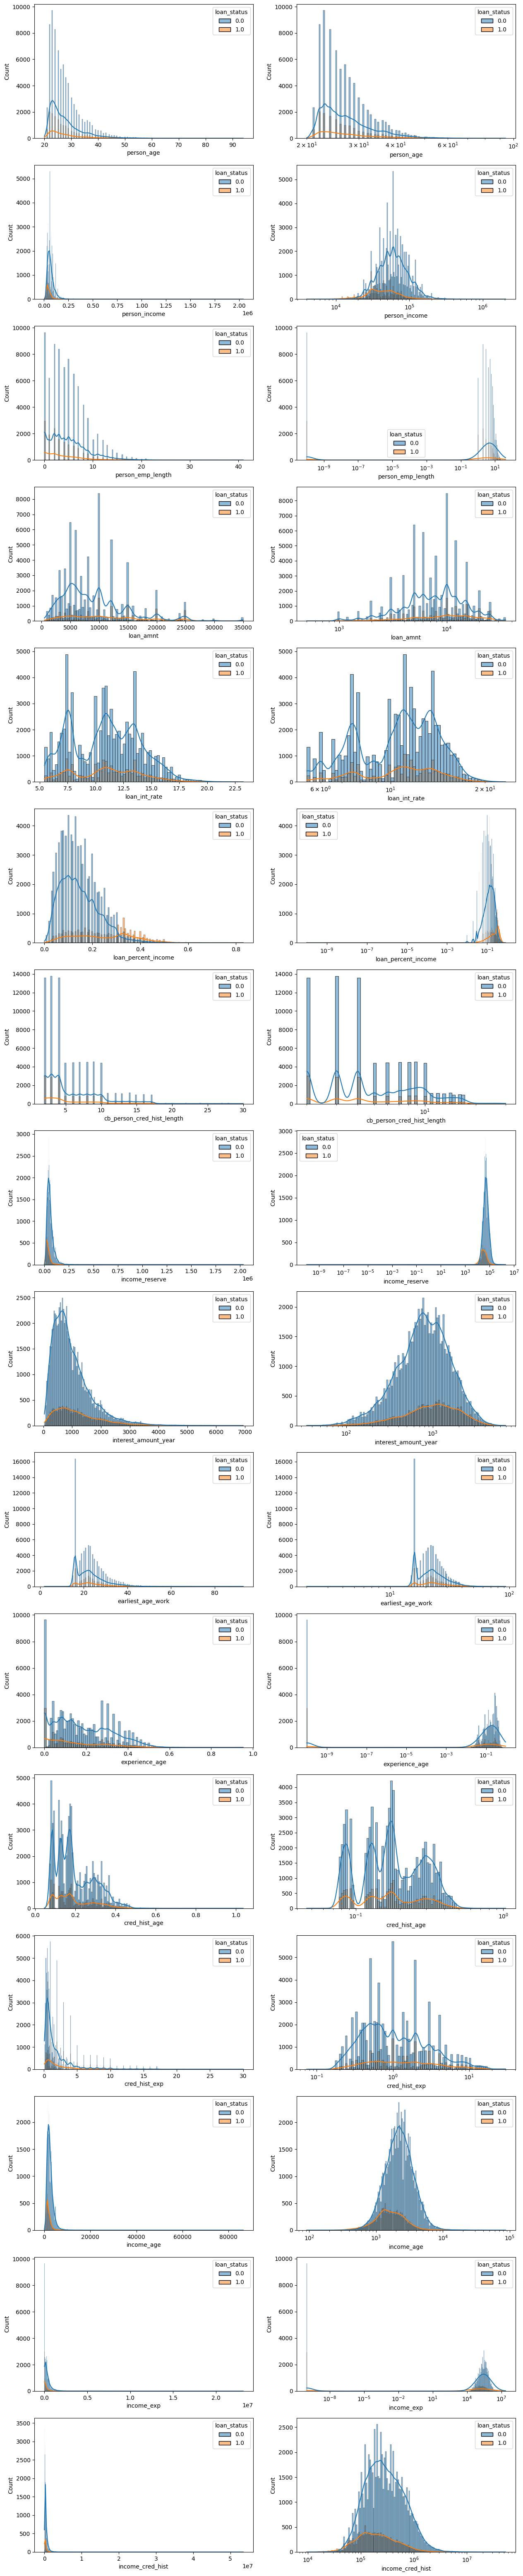

In [56]:
numeric_features_transform = ['person_age', 
                              'person_income', 
                              'person_emp_length', 
                              'loan_amnt', 
                              'loan_int_rate', 
                              'loan_percent_income', 
                              'cb_person_cred_hist_length',
                              'income_reserve',
                              'interest_amount_year',
                              'earliest_age_work',
                              'experience_age',
                              'cred_hist_age',
                              'cred_hist_exp',
                              'income_age',
                              'income_exp',
                              'income_cred_hist']

epsilon = 1e-10
for feature in numeric_features_transform:
    data_type_transformed[feature] = data_type_transformed[feature] + epsilon

fig, axs = plt.subplots(figsize=(15,5*len(numeric_features_transform)),nrows=len(numeric_features_transform), ncols=2)
for index,feature in enumerate(numeric_features_transform):
    sns.histplot(data_type_transformed, x=feature,hue=target_column,ax=axs[index][0],kde=True,log_scale=False)
    sns.histplot(data_type_transformed, x=feature,hue=target_column,ax=axs[index][1],kde=True,log_scale=True)

In [57]:
log_features = ["person_age",  "person_income", "person_emp_length", "income_reserve", "interest_amount_year", "cred_hist_age", "cred_hist_exp", "income_age", "income_exp", "income_cred_hist"]
standard_features = numeric_features_transform.copy()

log1p_transformer = LogCpTransformer(variables=log_features)
standard_transformer = SklearnTransformerWrapper(StandardScaler(),variables=standard_features)

In [58]:
data_log_scaled = log1p_transformer.fit_transform(data_type_transformed)
data_std_scaled = standard_transformer.fit_transform(data_log_scaled)

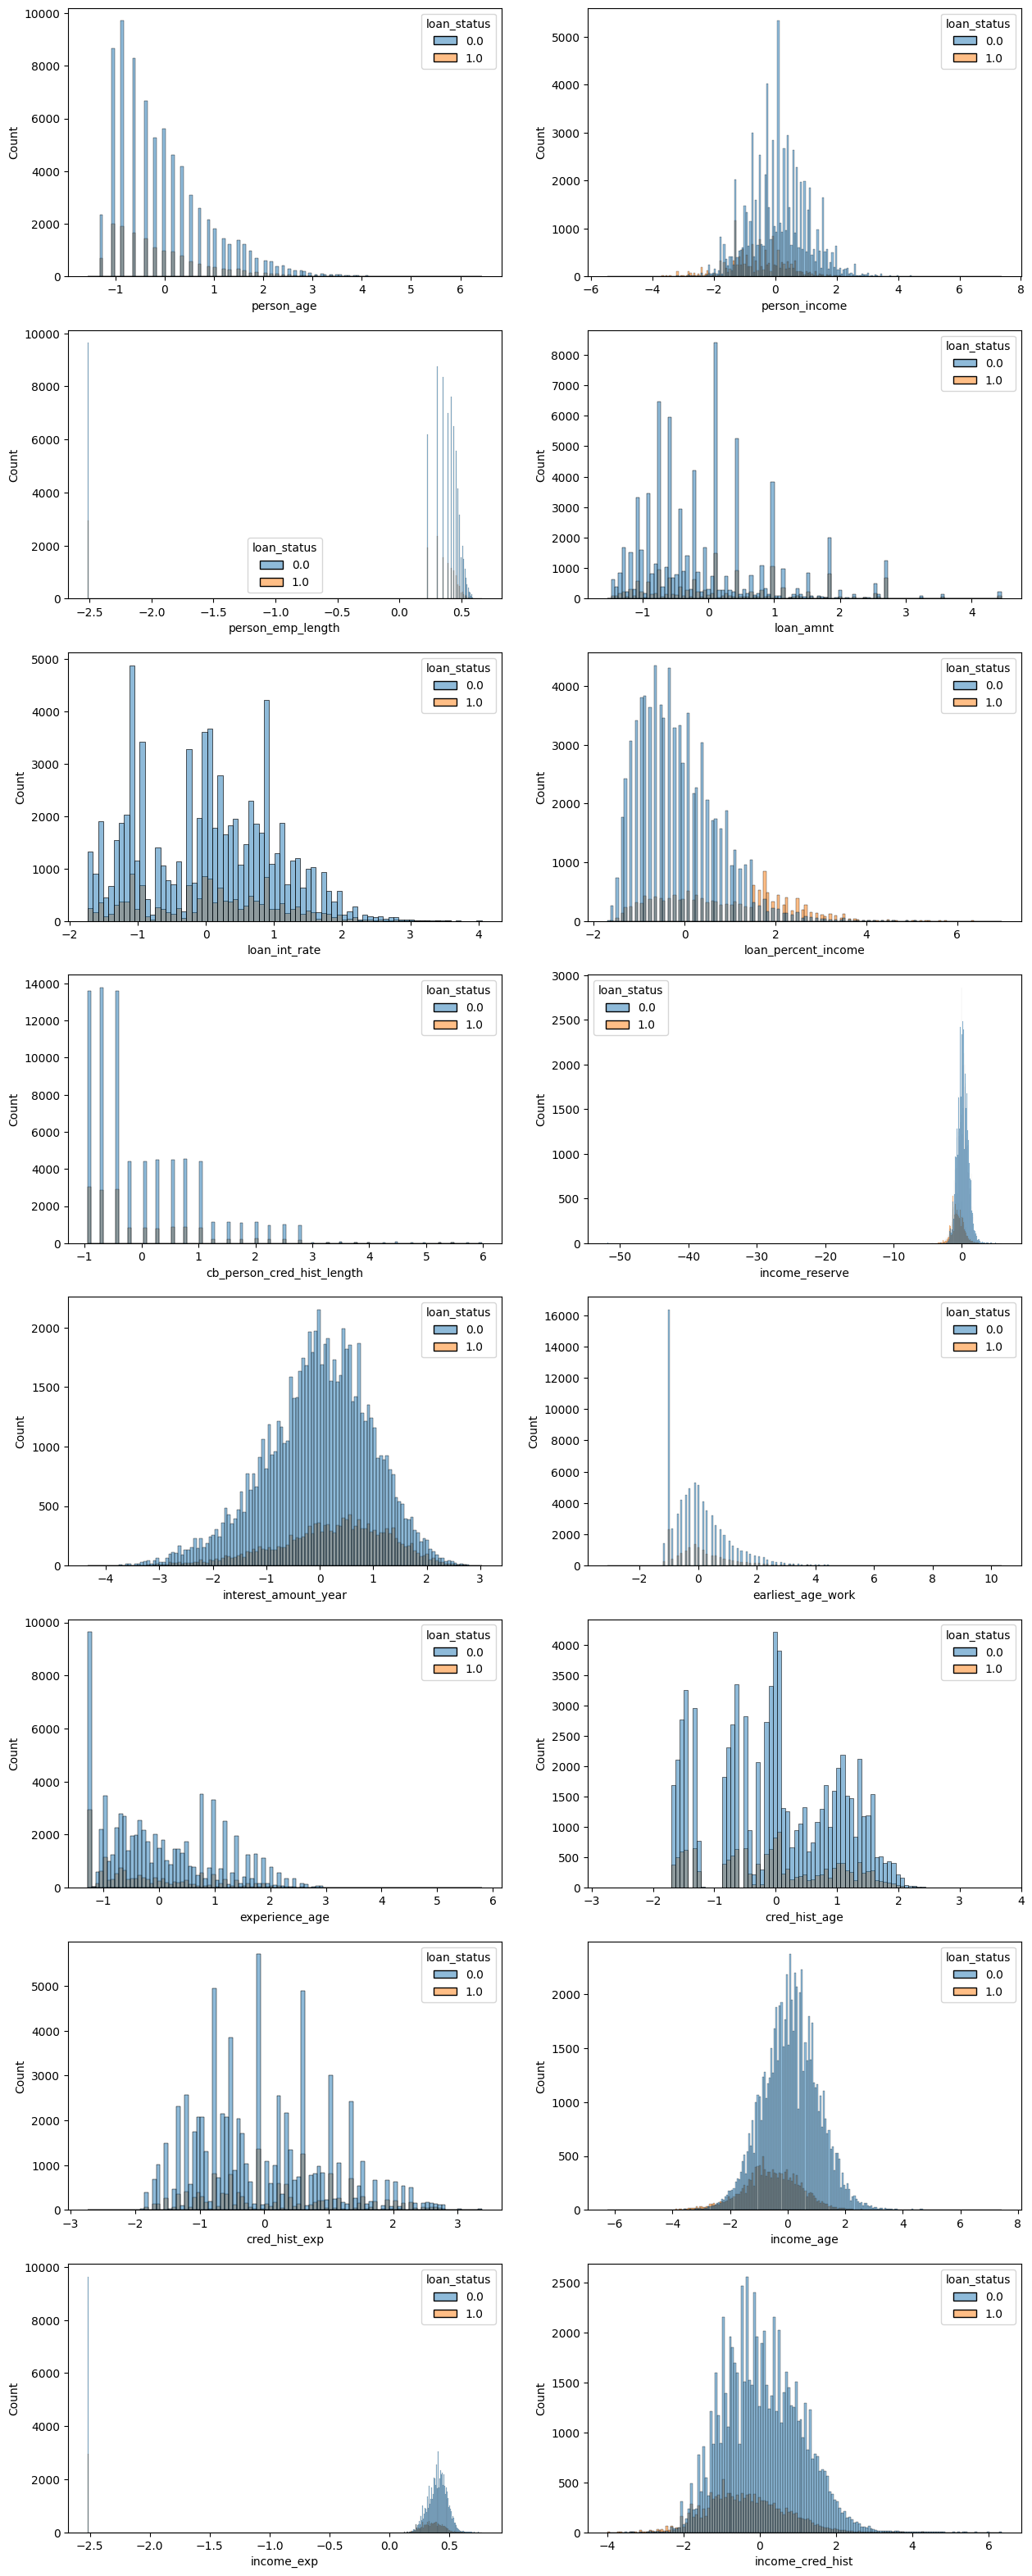

In [59]:
fig, axs = plt.subplots(figsize=(15,5*len(standard_features)//2),nrows=len(numeric_features_transform)//2, ncols=2)

for index,feature in enumerate(numeric_features_transform):
    sns.histplot(data_std_scaled, x=feature,hue=target_column,ax=axs[index//2][index%2])

In [60]:
quantile_6_bins = ['person_age', 'person_emp_length', 'loan_int_rate', 'loan_percent_income', 'experience_age', 'cred_hist_age', 'cred_hist_exp']
quantile_4_bins = ['cb_person_cred_hist_length']
uniform_8_bins = ['loan_amnt']

quantile_bins6_transformer = EqualFrequencyDiscretiser(variables=quantile_6_bins,q=6,return_boundaries=True,return_object=True)
quantile_bins4_transformer = EqualFrequencyDiscretiser(variables=quantile_4_bins,q=4,return_boundaries=True,return_object=True)
uniform_bins8_transformer = EqualWidthDiscretiser(variables=uniform_8_bins,bins=8,return_boundaries=True,return_object=True)

In [61]:
data_binned = quantile_bins6_transformer.fit_transform(data_std_scaled)
data_binned = quantile_bins4_transformer.fit_transform(data_binned)
data_binned = uniform_bins8_transformer.fit_transform(data_binned)

In [62]:
data_binned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130314 entries, 0 to 130313
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   id                          130314 non-null  int64   
 1   person_age                  130314 non-null  object  
 2   person_income               130314 non-null  float64 
 3   person_home_ownership       130314 non-null  category
 4   person_emp_length           130314 non-null  object  
 5   loan_intent                 130314 non-null  category
 6   loan_grade                  130314 non-null  int64   
 7   loan_amnt                   130314 non-null  object  
 8   loan_int_rate               130314 non-null  object  
 9   loan_percent_income         130314 non-null  object  
 10  cb_person_default_on_file   130314 non-null  bool    
 11  cb_person_cred_hist_length  130314 non-null  object  
 12  loan_status                 91216 non-null   float64 
 13 

In [63]:
def column_name_cleaner(df):
    data = df.copy()

    data.columns = data.columns.str.replace(',', '_')
    data.columns = data.columns.str.replace('[', '}')
    data.columns = data.columns.str.replace(']', '{')

    return data

In [64]:
column_name_transformer = FunctionTransformer(column_name_cleaner)

In [92]:
test_id = test[['id']].copy()
train_data = train.drop('id', axis=1).drop('dataset',axis=1)
test_data = test.drop('id', axis=1).drop('dataset',axis=1)

In [93]:
train_data = outlier_remover.fit_transform(train_data)
# outliers have to be dropped earlier than the pipeline as pipeline only process the X input matrix and ignores y

X = train_data.drop(target_column, axis=1)
y = (train_data[target_column] == 1)

In [94]:
skf = StratifiedKFold(n_splits=10)

In [ ]:
logistic_pipeline = Pipeline([
    ('group_impute', group_impute_transformer),
    ('mode_impute', mode_impute_transformer),
    ('numeric_ft_eng', numeric_ft_transformer),
    ('binary_ft_eng', binary_ft_transformer),
    ('ordinal_enc', ordinal_transformer),
    ('log_scale', log1p_transformer),
    ('standard_scale', standard_transformer),
    ('quantile_6_bins', quantile_bins6_transformer),
    ('quantile_4_bins', quantile_bins4_transformer),
    ('uniform_8_bins', uniform_bins8_transformer),
    ('onehotencoder', ohe_transformer),
    ('column_name_cleaner', column_name_transformer),
    ('clf', LogisticRegression())
])

param_grid = {"clf__penalty": [None, 'l2', 'l1', 'elasticnet'], "clf__max_iter": [500, 1000, 2000]}
logistic_gs = GridSearchCV(estimator=logistic_pipeline, param_grid=param_grid, cv=skf, scoring='roc_auc',error_score='raise')
logistic_gs.fit(X, y)

print("Best parameters:", logistic_gs.best_params_)
print("Best CV accuracy:", logistic_gs.best_score_)

In [ ]:
dt_tmp_dir = TemporaryDirectory(prefix="sklearn_cache_dt_")
dt_pipeline = Pipeline([
    ('group_impute', group_impute_transformer),
    ('mode_impute', mode_impute_transformer),
    ('numeric_ft_eng', numeric_ft_transformer),
    ('binary_ft_eng', binary_ft_transformer),
    ('datatype_changer', datatype_transformer),
    ('onehotencoder', ohe_transformer),
    ('column_name_cleaner', column_name_transformer),
    ('clf', DecisionTreeClassifier())
], memory=None)

param_grid = {"clf__max_depth": [5,10,20,30,40,50,None], "clf__criterion": ["gini", "entropy"]}
dt_gs = GridSearchCV(estimator=dt_pipeline, param_grid=param_grid, cv=skf, n_jobs=-1, scoring='roc_auc')
dt_gs.fit(X, y)

print("Best parameters:", dt_gs.best_params_)
print("Best CV accuracy:", dt_gs.best_score_)

Best parameters: {'clf__criterion': 'gini', 'clf__max_depth': 5}
Best CV accuracy: 0.9098975110751428


In [ ]:
rf_tmp_dir = TemporaryDirectory(prefix="sklearn_cache_rf_")
rf_pipeline = Pipeline([
    ('group_impute', group_impute_transformer),
    ('mode_impute', mode_impute_transformer),
    ('numeric_ft_eng', numeric_ft_transformer),
    ('binary_ft_eng', binary_ft_transformer),
    ('datatype_changer', datatype_transformer),
    ('onehotencoder', ohe_transformer),
    ('column_name_cleaner', column_name_transformer),
    ('clf', RandomForestClassifier(n_jobs=-1))
], memory=None)

param_grid = {"clf__max_depth": [5,10,20,30,40,50,None], "clf__criterion": ["gini", "entropy"], "clf__n_estimators": [100,500,1000,2000]}
rf_gs = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, cv=skf, n_jobs=-1, scoring='roc_auc')
rf_gs.fit(X, y)

print("Best parameters:", rf_gs.best_params_)
print("Best CV accuracy:", rf_gs.best_score_)

In [ ]:
xgb_tmp_dir = TemporaryDirectory(prefix="sklearn_cache_xgb_")
xgb_pipeline = Pipeline([
    ('numeric_ft_eng', numeric_ft_transformer),
    ('binary_ft_eng', binary_ft_transformer),
    ('datatype_changer', datatype_transformer),
    ('onehotencoder', ohe_transformer),
    ('column_name_cleaner', column_name_transformer),
    ('clf', XGBClassifier(eval_metric='auc', enable_categorical=True, n_jobs=-1, device="cuda", verbosity=0))
], memory=None)

param_grid = {"clf__max_depth": [5,10,20,30,40,50,None], "clf__booster ": ["gbtree", "dart"], "clf__n_estimators": [100,500,1000,2000], 'clf__learning_rate': [0.01, 0.1, 0.2]}
xgb_gs = GridSearchCV(estimator=xgb_pipeline, param_grid=param_grid, cv=skf, n_jobs=-1, scoring='roc_auc')
xgb_gs.fit(X, y)

print("Best parameters:", xgb_gs.best_params_)
print("Best CV accuracy:", xgb_gs.best_score_)

In [ ]:
cb_tmp_dir = TemporaryDirectory(prefix="sklearn_cache_cb_")
cb_pipeline = Pipeline([
    ('numeric_ft_eng', numeric_ft_transformer),
    ('binary_ft_eng', binary_ft_transformer),
    ('datatype_changer', datatype_transformer),
    ('onehotencoder', ohe_transformer),
    ('column_name_cleaner',column_name_transformer),
    ('clf', CatBoostClassifier(eval_metric='AUC', early_stopping_rounds=200, silent=True, allow_writing_files=False, save_snapshot=False, thread_count=-1, task_type='GPU'))
], memory=None)

param_grid = {"clf__depth": [5,10,20,30,40,50,None], 'clf__learning_rate': [0.01, 0.1, 0.2], 'clf__iterations': [100,500,1000,2000]}
cb_gs = GridSearchCV(estimator=cb_pipeline, param_grid=param_grid, cv=skf, n_jobs=-1, scoring='roc_auc')
cb_gs.fit(X, y)

print("Best parameters:", cb_gs.best_params_)
print("Best CV accuracy:", cb_gs.best_score_)

In [ ]:
hgb_tmp_dir = TemporaryDirectory(prefix="sklearn_cache_hgb_")
hgb_pipeline = Pipeline([
    ('numeric_ft_eng', numeric_ft_transformer),
    ('binary_ft_eng', binary_ft_transformer),
    ('datatype_changer', datatype_transformer),
    ('onehotencoder', ohe_transformer),
    ('column_name_cleaner',column_name_transformer),
    ('clf', HistGradientBoostingClassifier(categorical_features="from_dtype", n_iter_no_change=200, scoring='roc_auc'))
], memory=None)

param_grid = {"clf__max_depth": [5,10,20,30,40,50,None], 'clf__learning_rate': [0.01, 0.1, 0.2], 'clf__max_iter': [100,500,1000,2000]}
hgb_gs = GridSearchCV(estimator=hgb_pipeline, param_grid=param_grid, cv=skf, n_jobs=-1, scoring='roc_auc')
hgb_gs.fit(X, y)

print("Best parameters:", hgb_gs.best_params_)
print("Best CV accuracy:", hgb_gs.best_score_)

In [ ]:
lgbm_tmp_dir = TemporaryDirectory(prefix="sklearn_cache_lgbm_")
lgbm_pipeline = Pipeline([
    ('numeric_ft_eng', numeric_ft_transformer),
    ('binary_ft_eng', binary_ft_transformer),
    ('datatype_changer', datatype_transformer),
    ('onehotencoder', ohe_transformer),
    ('column_name_cleaner',column_name_transformer),
    ('clf', LGBMClassifier(early_stopping_round=200, metric='auc', n_jobs=-1, device="gpu", gpu_platform_id=1, gpu_device_id=0, verbosity=0))
], memory=None)

param_grid = {"clf__max_depth": [5,10,20,30,40,50,-1], 'clf__learning_rate': [0.01, 0.1, 0.2], 'clf__n_estimators': [100,500,1000,2000], "clf__boosting_type": ['gbdt', 'dart'], 'clf__num_iterations': [100,500,1000,2000]}
lgbm_gs = GridSearchCV(estimator=lgbm_pipeline, param_grid=param_grid, cv=skf, n_jobs=-1, scoring='roc_auc')
lgbm_gs.fit(X, y)

print("Best parameters:", lgbm_gs.best_params_)
print("Best CV accuracy:", lgbm_gs.best_score_)

In [ ]:
def getPrediction(estimator, test_id, test_data, target):
    y_pred_submission = estimator.predict_proba(test_data)[:, 1] # use probabilities
    
    test_submission = test_id
    test_submission[target] = y_pred_submission

    return test_submission

In [ ]:
estimators = [logistic_gs.best_estimator_, dt_gs.best_estimator_, rf_gs.best_estimator_, xgb_gs.best_estimator_, cb_gs.best_estimator_, hgb_gs.best_estimator_, lgbm_gs.best_estimator_]
estimator_names = ["logistic", "dt", "rf", "xgb", "cb", "hgbc", "lgbm"]

for estimator, estimator_name in zip(estimators, estimator_names):
    test_submission = getPrediction(estimator, test_id, test_data, target_column)
    test_submission.to_csv(f"submissions/{estimator_name}.csv", index=False)